# M4ESTRO - Model evaluation

## Imports

In [2081]:
from typing import List, Dict, Any, Optional, Tuple, Set, Callable
import requests
import math
from enum import Enum
import os
from collections import defaultdict
import json
import time
from datetime import datetime, timedelta, timezone
import random
from concurrent.futures import ThreadPoolExecutor

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2082]:
VERSION = "v3.0"
DATASET = "test"   # train or test

## Data loading

In [2083]:
CSV_PATH: str = "C:/P/backend/LambdaPY/graph_manager/builder_service/local/csv_test"

In [2084]:
orders_df = pd.read_csv(f"{CSV_PATH}/order_{DATASET}.csv")
orders_df.tail()

,id,manufacturer_id,manufacturer_order_id,site_id,carrier_id,status,n_steps,tracking_link,tracking_number,manufacturer_creation_timestamp,manufacturer_estimated_delivery_timestamp,manufacturer_confirmed_delivery_timestamp,carrier_creation_timestamp,carrier_estimated_delivery_timestamp,carrier_confirmed_delivery_timestamp,SLS,SRS
5,54,1,7357,3,2,DELIVERED,12,https://www.ups.com/track?tracknum=1ZR46591041...,1ZR465910413316617,2025-05-09 11:10:00+00:00,2025-05-12 20:00:00+00:00,2025-05-16 04:47:00+00:00,2025-05-09 19:07:00+00:00,NaN,2025-05-12 13:21:00+00:00,0,0
6,100,1,8108,3,2,DELIVERED,12,https://www.ups.com/track?tracknum=1ZR46591041...,1ZR465910413368928,2025-07-11 13:39:00+00:00,2025-07-14 20:00:00+00:00,2025-07-15 08:04:00+00:00,2025-07-11 21:54:00+00:00,NaN,2025-07-15 14:59:00+00:00,0,0
7,12,1,6121,4,3,DELIVERED,12,https://www.fedex.com/fedextrack/?trknbr=43925...,439256767958,2025-01-23 15:59:00+00:00,2025-01-27 22:00:00+00:00,2025-01-28 11:58:00+00:00,2025-01-24 23:07:00+00:00,NaN,2025-01-28 11:50:00+00:00,0,0
8,60,1,7429,3,2,DELIVERED,12,https://www.ups.com/track?tracknum=1ZR46591041...,1ZR465910413322468,2025-05-16 10:01:00+00:00,2025-05-19 20:00:00+00:00,2025-05-20 06:04:00+00:00,2025-05-16 20:27:00+00:00,NaN,2025-05-19 14:28:00+00:00,0,0
9,93,1,7942,3,2,DELIVERED,11,https://www.ups.com/track?tracknum=1ZR46591041...,1ZR465910413361729,2025-07-01 10:41:00+00:00,2025-07-03 20:00:00+00:00,2025-07-15 07:08:00+00:00,2025-07-02 23:27:00+00:00,NaN,2025-07-10 13:43:00+00:00,0,0


In [2085]:
order_steps_enriched_df = pd.read_csv(f"{CSV_PATH}/order_steps_enriched_{DATASET}.csv")
order_steps_enriched_df.head()

,order_id,step_source,timestamp_source,location_source,step_destination,timestamp_destination,location_destination,hours,geodesic_km
0,12,1,2025-01-24 23:07:00+00:00,"GRAND PRAIRIE, TEXAS, US",2,2025-01-24 23:07:00+00:00,"GRAND PRAIRIE, TEXAS, US",0.000000,0.000000
1,12,2,2025-01-24 23:07:00+00:00,"GRAND PRAIRIE, TEXAS, US",3,2025-01-24 23:40:00+00:00,"MANSFIELD, TEXAS, US",0.550000,24.353223
2,12,3,2025-01-24 23:40:00+00:00,"MANSFIELD, TEXAS, US",4,2025-01-25 04:30:00+00:00,"NEW YORK, NEW YORK, US",4.833333,2249.220628
3,12,4,2025-01-25 04:30:00+00:00,"NEW YORK, NEW YORK, US",5,2025-01-25 11:17:00+00:00,"NEW YORK, NEW YORK, US",6.783333,0.000000
4,12,5,2025-01-25 11:17:00+00:00,"NEW YORK, NEW YORK, US",6,2025-01-25 19:06:00+00:00,"PARIS, ÎLE-DE-FRANCE, FR",7.816667,5852.736948


In [2086]:
sites_df = pd.read_csv(f"{CSV_PATH}/site.csv")
sites_df.head()

,id,supplier_id,location_name,n_rejections,n_orders,consider_closure_holidays,consider_working_holidays,consider_weekends_holidays
0,1,1,"LEEDS, ENGLAND, GB",0,5,True,True,True
1,2,2,"LOUISVILLE, KENTUCKY, US",0,3,True,True,True
2,3,2,"THIEF RIVER FALLS, MINNESOTA, US",0,61,True,True,True
3,4,3,"GRAND PRAIRIE, TEXAS, US",0,5,True,True,True
4,5,4,"MONTAGNOLA, TICINO, CH",0,1,True,True,True


In [2087]:
suppliers_df = pd.read_csv(f"{CSV_PATH}/supplier.csv")
suppliers_df.head()

,id,manufacturer_supplier_id,name
0,1,1,FARNELL
1,2,2,DIGIKEY
2,3,3,MOUSER
3,4,4,AUTO SUPPLY
4,5,8,SAFE


In [2088]:
carriers_df = pd.read_csv(f"{CSV_PATH}/carrier.csv")
carriers_df.head()

,id,name,carrier_17track_id,n_losses,n_orders
0,1,DHL Express,100001,0,5
1,2,UPS,100002,0,72
2,3,FedEx,100003,0,13
3,4,DHL,100004,0,16
4,5,DPD,100005,0,0


In [2089]:
manufacturers_df = pd.read_csv(f"{CSV_PATH}/manufacturer.csv")
manufacturers_df.head()

,id,location_name,name
0,1,"GAZZANIGA, LOMBARDY, IT",FAE


## Estimation

### URLs

In [2090]:
API_URL = "https://rhwompporf.execute-api.eu-central-1.amazonaws.com/dev"
ROOT_URL = f"{API_URL}/"

WARMING_URL = f"{ROOT_URL}lcdi/realtime/"
ESTIMATION_URL = f"{ROOT_URL}lcdi/realtime/volatile"
DB_URL = f"{ROOT_URL}db"

DB_URL, ESTIMATION_URL, WARMING_URL

('https://rhwompporf.execute-api.eu-central-1.amazonaws.com/dev/db',
 'https://rhwompporf.execute-api.eu-central-1.amazonaws.com/dev/lcdi/realtime/volatile',
 'https://rhwompporf.execute-api.eu-central-1.amazonaws.com/dev/lcdi/realtime/')

In [2091]:
class Stage(Enum):
    DISPATCH = "dispatch"
    SHIPMENT = "shipment"
    DELIVERY = "delivery"

### Requests body construction

In [2092]:
def require_estimation(url: str, data: Dict[str, Any] | List[Dict[str, Any]]) -> List[Dict[str, Any]] | Dict[str, Any]:
    """
    Make a POST request to the estimation API.
    """
    response = requests.post(url=url, json=data)
    response.raise_for_status()
    return response.json()

In [2093]:
def create_estimation_request_body(
    vertex_name: str,
    vertex_type: str,
    site_id: int,
    carrier_id: int,
    order_time: datetime,
    event_time: datetime,
    estimation_time: datetime,
    maybe_shipment_time: Optional[datetime] = None,
) -> Dict[str, Any]:

    return {
        "vertex": {
            "vertexName": vertex_name,
            "vertexType": vertex_type,
        },
        "carrier": {
            "carrierId": carrier_id,
        },
        "site": {
            "siteId": site_id,
        },
        "orderTime": order_time.isoformat(),
        "shipmentTime": maybe_shipment_time.isoformat() if maybe_shipment_time else None,
        "eventTime": event_time.isoformat(),
        "estimationTime": estimation_time.isoformat(),
    }

In [2094]:
manufacturer_name: str = manufacturers_df.iloc[0]["name"]
manufacturer_name

'FAE'

In [2095]:
requests_dispatch_body: List[Dict[str, Any]] = []
dispatch_order_ids: List[int] = []

requests_shipment_body: List[Dict[str, Any]] = []
shipment_order_ids: List[int] = []

requests_delivery_body: List[Dict[str, Any]] = []
delivery_order_ids: List[int] = []

bad_orders_ids: Set[int] = set()

for i, row in order_steps_enriched_df.iterrows():
    order_row: pd.Series = orders_df[orders_df["id"] == row["order_id"]].iloc[0]
    order_id: int = order_row["id"]

    site_id: int = int(order_row["site_id"])
    carrier_id: int = int(order_row["carrier_id"])

    order_time: datetime = pd.to_datetime(order_row["manufacturer_creation_timestamp"])
    shipment_time: datetime = pd.to_datetime(order_row["carrier_creation_timestamp"])
    delivery_time: datetime = pd.to_datetime(order_row['carrier_confirmed_delivery_timestamp'])

    step_source: int = row["step_source"]
    step_destination: int = row["step_destination"]

    event_time: datetime = pd.to_datetime(row["timestamp_source"])
    estimation_time: datetime = event_time

    if not order_time <= shipment_time <= event_time <= estimation_time:
        print(f"Order ID {order_id} has invalid times: "
              f"order_time={order_time}, shipment_time={shipment_time}, "
              f"event_time={event_time}, estimation_time={estimation_time}")
        bad_orders_ids.add(order_id)
        continue

    if step_source == 1:
        vertex_name: str = str(site_id)
        vertex_type: str = "SUPPLIER_SITE"
        requests_dispatch_body.append(create_estimation_request_body(            # Estimation for when the order is still in dispatch
            vertex_name=vertex_name,
            vertex_type=vertex_type,
            site_id=site_id,
            carrier_id=carrier_id,
            order_time=order_time,
            event_time=order_time,
            estimation_time=order_time
        ))
        dispatch_order_ids.append(int(order_id))
    else:
        vertex_name: str = row["location_source"]
        vertex_type: str = "INTERMEDIATE"
        
    request_body: Dict[str, Any] = create_estimation_request_body(      # Estimation for the carrier event
        vertex_name=vertex_name,
        vertex_type=vertex_type,
        site_id=site_id,
        carrier_id=carrier_id,
        order_time=order_time,
        maybe_shipment_time=shipment_time,
        event_time=event_time,
        estimation_time=estimation_time,
    )
    requests_shipment_body.append(request_body)
    shipment_order_ids.append(int(order_id))

    if step_destination == order_row["n_steps"]:
        requests_delivery_body.append(create_estimation_request_body(            # Estimation for the last event (delivery to the manufacturer)
            vertex_name=manufacturer_name,
            vertex_type="MANUFACTURER",
            site_id=site_id,
            carrier_id=carrier_id,
            order_time=order_time,
            maybe_shipment_time=shipment_time,
            event_time=pd.to_datetime(row['timestamp_destination']),
            estimation_time=pd.to_datetime(row['timestamp_destination']),
        ))
        delivery_order_ids.append(int(order_id))

len(requests_dispatch_body), len(requests_shipment_body), len(requests_delivery_body)

(10, 106, 10)

In [2096]:
bad_orders_ids_steps_df = order_steps_enriched_df[order_steps_enriched_df["order_id"].isin(bad_orders_ids)]
assert len(requests_dispatch_body) + len(requests_shipment_body) + len(requests_delivery_body) == len(order_steps_enriched_df) + 2 * len(orders_df) - (len(bad_orders_ids_steps_df) + 2 * len(bad_orders_ids))

In [2097]:
requests_dispatch_body[2]

{'vertex': {'vertexName': '3', 'vertexType': 'SUPPLIER_SITE'},
 'carrier': {'carrierId': 2},
 'site': {'siteId': 3},
 'orderTime': '2025-04-23T09:46:00+00:00',
 'shipmentTime': None,
 'eventTime': '2025-04-23T09:46:00+00:00',
 'estimationTime': '2025-04-23T09:46:00+00:00'}

### Estimation computation

In [2098]:
def chunked(iterable: List, size: int):
    for i in range(0, len(iterable), size):
        yield iterable[i:i + size]

In [2099]:
def execute_chunk_estimation(chunk: List[Dict[str, Any]], i: int) -> Any:
    print(f"Processing chunk {i} of size: {len(chunk)}")
    starting_time: float = time.time()
    result: Any = require_estimation(url=ESTIMATION_URL, data=chunk)
    elapsed_time: float = time.time() - starting_time
    print(f"\tChunk {i} processed in {elapsed_time:.2f} seconds")
    return result

In [2100]:
estimation_response_by_stage: Dict[str, List[Dict[str, Any]]] = {}

#### Lambda warming utility

In [2101]:
def warm_lambda(url: str = WARMING_URL) -> None:
    q_params = {"order": 1}
    response = requests.get(url, params=q_params)
    response.raise_for_status()

#### Dispatch

In [2102]:
warm_lambda()

In [2103]:
CHUNK_SIZE: int = 2
MAX_WORKERS: int = 10

chunks = list(chunked(requests_dispatch_body, CHUNK_SIZE))
assert CHUNK_SIZE * (len(chunks) - 1) + len(chunks[-1]) == len(requests_dispatch_body)
len(chunks)

5

In [2104]:
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    dispatch_estimation_responses_chunked = list(executor.map(execute_chunk_estimation, chunks, list(range(len(chunks)))))

len(dispatch_estimation_responses_chunked)

Processing chunk 0 of size: 2
Processing chunk 1 of size: 2
Processing chunk 2 of size: 2
Processing chunk 3 of size: 2
Processing chunk 4 of size: 2
	Chunk 0 processed in 1.32 seconds
	Chunk 1 processed in 1.35 seconds
	Chunk 2 processed in 1.39 seconds
	Chunk 4 processed in 1.42 seconds
	Chunk 3 processed in 2.05 seconds


5

Sanity check:

In [2105]:
assert len(dispatch_estimation_responses_chunked) == len(chunks)
for i, chunk in enumerate(chunks):
    response_chunk: List[Dict[str, Any]] = dispatch_estimation_responses_chunked[i]
    assert len(response_chunk) == len(chunk), f"Chunk {i} response length mismatch: expected {len(chunk)}, got {len(response_chunk)}"
    for j, request in enumerate(chunk):
        response: Dict[str, Any] = response_chunk[j]
        assert response['site']['id'] == request['site']['siteId']
        assert response['carrier']['id'] == request['carrier']['carrierId']
        assert response['vertex']['name'] == request['vertex']['vertexName']
        assert response['vertex']['type'] == request['vertex']['vertexType']
        assert response['order_time'] == request['orderTime']
        assert response['event_time'] == request['eventTime']
        if 'shipmentTime' in request and request['shipmentTime']:
            assert response['shipment_time'] == request['shipmentTime']


In [2106]:
dispatch_estimation_responses = []
for chunk in dispatch_estimation_responses_chunked:
    dispatch_estimation_responses.extend(chunk)

estimation_response_by_stage[Stage.DISPATCH.value] = dispatch_estimation_responses

len(dispatch_estimation_responses_chunked), len(dispatch_estimation_responses)

(5, 10)

In [2107]:
for order_id, response in zip(dispatch_order_ids, dispatch_estimation_responses):
    response['order_id'] = order_id

dispatch_estimation_responses[0]

{'site': {'id': 4, 'location': 'GRAND PRAIRIE, TEXAS, US'},
 'supplier': {'id': 3, 'manufacturer_id': 3, 'name': 'MOUSER'},
 'carrier': {'id': 3, 'name': 'FedEx'},
 'manufacturer': {'id': 1,
  'name': 'FAE',
  'location': 'GAZZANIGA, LOMBARDY, IT'},
 'vertex': {'id': 21, 'name': '4', 'type': 'SUPPLIER_SITE'},
 'order_time': '2025-01-23T15:59:00+00:00',
 'shipment_time': '2025-01-24T11:18:00.001200+00:00',
 'event_time': '2025-01-23T15:59:00+00:00',
 'estimation_time': '2025-01-23T15:59:00+00:00',
 'status': 'PENDING',
 'indicators': {'parameters': {'DT': {'holidays': {'consider_closure_holidays': True,
     'consider_working_holidays': True,
     'consider_weekends_holidays': True},
    'confidence': 0.9},
   'alpha': {'type': 'EXP', 'tt_weight': 0.5},
   'PT': {'rte_estimator_params': {'model_mape': 0.4438, 'use_model': True},
    'tmi_params': {'speed_parameters': {'air_min_speed_km_h': 200.0,
      'air_max_speed_km_h': 1000.0,
      'sea_min_speed_km_h': 10.0,
      'sea_max_speed_

#### Shipment

In [2108]:
warm_lambda()

In [2109]:
CHUNK_SIZE = 1
MAX_WORKERS = 50

In [2110]:
chunks = list(chunked(requests_shipment_body, CHUNK_SIZE))
assert CHUNK_SIZE * (len(chunks) - 1) + len(chunks[-1]) == len(requests_shipment_body)
len(chunks)

106

In [2111]:
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    shipment_estimation_responses_chunked = list(executor.map(execute_chunk_estimation, chunks, list(range(len(chunks)))))

len(shipment_estimation_responses_chunked)

Processing chunk 0 of size: 1
Processing chunk 1 of size: 1
Processing chunk 2 of size: 1
Processing chunk 3 of size: 1
Processing chunk 4 of size: 1
Processing chunk 5 of size: 1
Processing chunk 6 of size: 1
Processing chunk 7 of size: 1
Processing chunk 8 of size: 1
Processing chunk 9 of size: 1
Processing chunk 10 of size: 1
Processing chunk 11 of size: 1
Processing chunk 12 of size: 1
Processing chunk 13 of size: 1
Processing chunk 14 of size: 1
Processing chunk 15 of size: 1
Processing chunk 16 of size: 1
Processing chunk 17 of size: 1
Processing chunk 18 of size: 1
Processing chunk 19 of size: 1
Processing chunk 20 of size: 1
Processing chunk 21 of size: 1
Processing chunk 22 of size: 1
Processing chunk 23 of size: 1
Processing chunk 24 of size: 1
Processing chunk 25 of size: 1
Processing chunk 26 of size: 1
Processing chunk 27 of size: 1
Processing chunk 28 of size: 1
Processing chunk 29 of size: 1
Processing chunk 30 of size: 1
Processing chunk 31 of size: 1
Processing chunk 3

106

Sanity check:

In [2112]:
assert len(shipment_estimation_responses_chunked) == len(chunks)

chunk_index_pairs_to_drop: Set[Tuple[int, int]] = set()

for i, chunk in enumerate(chunks):
    response_chunk: List[Dict[str, Any]] = shipment_estimation_responses_chunked[i]
    assert len(response_chunk) == len(chunk), f"Chunk {i} response length mismatch: expected {len(chunk)}, got {len(response_chunk)}"
    for j, request in enumerate(chunk):
        response: Dict[str, Any] = response_chunk[j]
        try:
            assert response['site']['id'] == request['site']['siteId'], f"Mismatch in site ID for chunk {i}, request {j}: expected {request['site']['siteId']}, got {response['site']['id']}"
            assert response['carrier']['id'] == request['carrier']['carrierId']
            assert response['vertex']['name'] == request['vertex']['vertexName']
            assert response['vertex']['type'] == request['vertex']['vertexType']
            assert response['order_time'] == request['orderTime']
            assert response['event_time'] == request['eventTime']
            if 'shipmentTime' in request and request['shipmentTime']:
                assert response['shipment_time'] == request['shipmentTime'], f"Mismatch in shipment time for chunk {i}, request {j}: expected {request['shipmentTime']}, got {response['shipment_time']}"
        except Exception as e:
            print(f"Error in chunk {i}, request {j}: {response['message']}")
            chunk_index_pairs_to_drop.add((i, j))

len(chunk_index_pairs_to_drop)

0

In [2113]:
global_index: int = 0
validated_count: int = 0

shipment_validated_order_ids: List[int] = []
shipment_estimation_responses: List[Dict[str, Any]] = []

for i, chunk in enumerate(shipment_estimation_responses_chunked):
    for j, response in enumerate(chunk):
        if (i, j) in chunk_index_pairs_to_drop:
            print(f"Chunk {i}, request {j} dropped due to errors")
            global_index += 1
            continue

        order_id: int = shipment_order_ids[global_index]

        shipment_validated_order_ids.append(order_id)        
        shipment_estimation_responses.append(response)

        validated_count += 1
        global_index += 1

assert validated_count == len(shipment_estimation_responses)
assert validated_count == len(requests_shipment_body) - len(chunk_index_pairs_to_drop)
assert validated_count == len(shipment_validated_order_ids)

validated_count, len(shipment_validated_order_ids), len(chunk_index_pairs_to_drop) 

(106, 106, 0)

In [2114]:
for order_id, response in zip(shipment_validated_order_ids, shipment_estimation_responses):
    response['order_id'] = order_id

shipment_estimation_responses[0]

{'site': {'id': 4, 'location': 'GRAND PRAIRIE, TEXAS, US'},
 'supplier': {'id': 3, 'manufacturer_id': 3, 'name': 'MOUSER'},
 'carrier': {'id': 3, 'name': 'FedEx'},
 'manufacturer': {'id': 1,
  'name': 'FAE',
  'location': 'GAZZANIGA, LOMBARDY, IT'},
 'vertex': {'id': 21, 'name': '4', 'type': 'SUPPLIER_SITE'},
 'order_time': '2025-01-23T15:59:00+00:00',
 'shipment_time': '2025-01-24T23:07:00+00:00',
 'event_time': '2025-01-24T23:07:00+00:00',
 'estimation_time': '2025-01-24T23:07:00+00:00',
 'status': 'IN_TRANSIT',
 'indicators': {'parameters': {'DT': {'holidays': {'consider_closure_holidays': True,
     'consider_working_holidays': True,
     'consider_weekends_holidays': True},
    'confidence': 0.9},
   'alpha': {'type': 'EXP', 'tt_weight': 0.5},
   'PT': {'rte_estimator_params': {'model_mape': 0.4438, 'use_model': True},
    'tmi_params': {'speed_parameters': {'air_min_speed_km_h': 200.0,
      'air_max_speed_km_h': 1000.0,
      'sea_min_speed_km_h': 10.0,
      'sea_max_speed_km_h

In [2115]:
estimation_response_by_stage[Stage.SHIPMENT.value] = shipment_estimation_responses

#### Delivery

In [2116]:
warm_lambda()

In [2117]:
CHUNK_SIZE = 40
MAX_WORKERS = 10

chunks = list(chunked(requests_delivery_body, CHUNK_SIZE))
assert CHUNK_SIZE * (len(chunks) - 1) + len(chunks[-1]) == len(requests_delivery_body)
len(chunks)

1

In [2118]:
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    delivery_estimation_responses_chunked = list(executor.map(execute_chunk_estimation, chunks, list(range(len(chunks)))))

len(delivery_estimation_responses_chunked)

Processing chunk 0 of size: 10
	Chunk 0 processed in 4.55 seconds


1

Sanity check:

In [2119]:
assert len(delivery_estimation_responses_chunked) == len(chunks)

chunk_index_pairs_to_drop: Set[Tuple[int, int]] = set()

for i, chunk in enumerate(chunks):
    response_chunk: List[Dict[str, Any]] = delivery_estimation_responses_chunked[i]
    assert len(response_chunk) == len(chunk), f"Chunk {i} response length mismatch: expected {len(chunk)}, got {len(response_chunk)}"
    for j, request in enumerate(chunk):
        try:
            response: Dict[str, Any] = response_chunk[j]
            assert response['site']['id'] == request['site']['siteId'], f"Mismatch in site ID for chunk {i}, request {j}: expected {request['site']['siteId']}, got {response['site']['id']}"
            assert response['carrier']['id'] == request['carrier']['carrierId']
            assert response['vertex']['name'] == request['vertex']['vertexName']
            assert response['vertex']['type'] == request['vertex']['vertexType']
            assert response['order_time'] == request['orderTime']
            assert response['event_time'] == request['eventTime']
            if 'shipmentTime' in request and request['shipmentTime']:
                assert response['shipment_time'] == request['shipmentTime'], f"Mismatch in shipment time for chunk {i}, request {j}: expected {request['shipmentTime']}, got {response['shipment_time']}"
        except Exception as e:
            print(f"Error in chunk {i}, request {j}: {e}")
            chunk_index_pairs_to_drop.add((i, j))

len(chunk_index_pairs_to_drop)

0

In [2120]:
validated_count: int = 0

delivery_validated_order_ids: List[int] = []
delivery_estimation_requests: List[Dict[str, Any]] = []
delivery_estimation_responses: List[Dict[str, Any]] = []

global_index = 0
for i, chunk in enumerate(delivery_estimation_responses_chunked):
    for j, response in enumerate(chunk):
        if (i, j) in chunk_index_pairs_to_drop:
            print(f"Chunk {i}, request {j} dropped due to errors")
            global_index += 1
            continue

        order_id: int = delivery_order_ids[global_index]
        request: Dict[str, Any] = requests_delivery_body[global_index]

        delivery_validated_order_ids.append(order_id)
        delivery_estimation_requests.append(request)
        delivery_estimation_responses.append(response)

        validated_count += 1
        global_index += 1

assert validated_count == len(delivery_estimation_responses)
assert validated_count == len(requests_delivery_body) - len(chunk_index_pairs_to_drop)
assert validated_count == len(delivery_validated_order_ids)
assert validated_count == len(delivery_estimation_requests)

validated_count, len(delivery_validated_order_ids), len(chunk_index_pairs_to_drop) 

(10, 10, 0)

In [2121]:
for order_id, request, response in zip(delivery_validated_order_ids, delivery_estimation_requests, delivery_estimation_responses):
    request_site_id: int = request['site']['siteId']
    order_site_id: int = orders_df[orders_df['id'] == order_id]['site_id'].values[0]
    response_site_id: int = response['site']['id']

    assert request_site_id == order_site_id, f"Site ID mismatch for order {order_id}: expected {order_site_id}, got {request_site_id}"
    assert response_site_id == order_site_id, f"Site ID mismatch for order {order_id}: expected {order_site_id}, got {response_site_id}"

In [2122]:
for order_id, response in zip(delivery_validated_order_ids, delivery_estimation_responses):
    response['order_id'] = order_id
    
    response_site_id: int = response['site']['id']
    order_site_id: int = orders_df[orders_df['id'] == order_id]['site_id'].values[0]
    assert response_site_id == order_site_id, f"Site ID mismatch for order {order_id}: expected {order_site_id}, got {response_site_id}"

delivery_estimation_responses[0]

{'site': {'id': 4, 'location': 'GRAND PRAIRIE, TEXAS, US'},
 'supplier': {'id': 3, 'manufacturer_id': 3, 'name': 'MOUSER'},
 'carrier': {'id': 3, 'name': 'FedEx'},
 'manufacturer': {'id': 1,
  'name': 'FAE',
  'location': 'GAZZANIGA, LOMBARDY, IT'},
 'vertex': {'id': 34, 'name': 'FAE', 'type': 'MANUFACTURER'},
 'order_time': '2025-01-23T15:59:00+00:00',
 'shipment_time': '2025-01-24T23:07:00+00:00',
 'event_time': '2025-01-28T11:50:00+00:00',
 'estimation_time': '2025-01-28T11:50:00+00:00',
 'status': 'DELIVERED',
 'indicators': {'parameters': {'DT': {'holidays': {'consider_closure_holidays': True,
     'consider_working_holidays': True,
     'consider_weekends_holidays': True},
    'confidence': 0.9},
   'alpha': {'type': 'EXP', 'tt_weight': 0.5},
   'PT': {'rte_estimator_params': {'model_mape': 0.4438, 'use_model': True},
    'tmi_params': {'speed_parameters': {'air_min_speed_km_h': 200.0,
      'air_max_speed_km_h': 1000.0,
      'sea_min_speed_km_h': 10.0,
      'sea_max_speed_km_h

In [2123]:
estimation_response_by_stage[Stage.DELIVERY.value] = delivery_estimation_responses

#### Overall

In [2124]:
ALLOW_MODIFY = True  
if not ALLOW_MODIFY:
    assert False, "Modifications are not allowed in this run."

RESULTS_PATH: str = "./results_final"
if not os.path.exists(RESULTS_PATH):
    os.makedirs(RESULTS_PATH)

VERSION_PATH: str = f"{RESULTS_PATH}/{VERSION}"
if not os.path.exists(VERSION_PATH):
    os.makedirs(VERSION_PATH)

DATASET_PATH = f"{VERSION_PATH}/{DATASET}"
if not os.path.exists(DATASET_PATH):
    os.makedirs(DATASET_PATH)

RESULTS_FILEPATH = f"{DATASET_PATH}/results.json"

PLOTS_PATH = f"{DATASET_PATH}/plots"
if not os.path.exists(PLOTS_PATH):
    os.makedirs(PLOTS_PATH)

In [2125]:
len(estimation_response_by_stage[Stage.DISPATCH.value]), len(estimation_response_by_stage[Stage.SHIPMENT.value]), len(estimation_response_by_stage[Stage.DELIVERY.value])

(10, 106, 10)

In [2126]:
with open(f"{DATASET_PATH}/estimations.json", "w") as f:
    json.dump(estimation_response_by_stage, f, indent=4)

In [2127]:
with open(f"{DATASET_PATH}/estimations.json", "r") as f:
    estimation_response_by_stage = json.load(f)

len(estimation_response_by_stage[Stage.DISPATCH.value]), len(estimation_response_by_stage[Stage.SHIPMENT.value]), len(estimation_response_by_stage[Stage.DELIVERY.value])

(10, 106, 10)

In [2128]:
dispatch_estimation_responses: List[Dict[str, Any]] = estimation_response_by_stage[Stage.DISPATCH.value]
shipment_estimation_responses: List[Dict[str, Any]] = estimation_response_by_stage[Stage.SHIPMENT.value]
delivery_estimation_responses: List[Dict[str, Any]] = estimation_response_by_stage[Stage.DELIVERY.value]

## Evaluation

### Evaluation functions

In [2129]:
OVERALL_KEY: str = "overall"
DISPATCH_KEY: str = "dispatch"
SHIPMENT_KEY: str = "shipment"

#### Dispatch:

##### Window size

In [2130]:
def evaluate_dispatch_window_size(
    stage: Stage,
    estimation_responses: List[Dict[str, Any]],
    results: Dict[str, Any],
    plots_path: str = PLOTS_PATH
) -> None:
    window_sizes_data: List[float] = []
    for estimation in estimation_responses:
        indicators = estimation["indicators"]
        dt_values: Dict[str, Any] = indicators["DT"]['total']['value']['total']
        lb: float = dt_values["lower"]
        ub: float = dt_values["upper"]
        window_size: float = ub - lb
        window_sizes_data.append(window_size)

    # Convert to numpy array and compute statistics
    window_sizes = np.array(window_sizes_data)
    mean = np.mean(window_sizes)
    median = np.median(window_sizes)
    std = np.std(window_sizes, ddof=1)
    min_val = float(np.min(window_sizes))
    max_val = float(np.max(window_sizes))

    if not stage.value in results:
        results[stage.value] = {}
    if not DISPATCH_KEY in results[stage.value]:
        results[stage.value][DISPATCH_KEY] = {}

    # Store results
    results[stage.value][DISPATCH_KEY]["window_sizes"] = {
        "data": window_sizes_data,
        "count": len(window_sizes_data),
        "mean": float(mean),
        "median": float(median),
        "std": float(std),
        "min": min_val,
        "max": max_val,
    }

    # Console output
    print(f"Dispatch window sizes for {stage.value} stage:")
    print(f"\tCount: {len(window_sizes)}")
    print(f"\tMean: {mean}")
    print(f"\tMedian: {median}")
    print(f"\tStd: {std}")
    print(f"\tMin: {min_val}")
    print(f"\tMax: {max_val}")

    # Plot histogram
    plt.figure(figsize=(10, 5))
    plt.hist(window_sizes, bins=10, alpha=0.75, color='steelblue',
             edgecolor='black', linewidth=0.8, density=True)
    plt.axvline(float(mean), color='black', linestyle='--', linewidth=1, label=f'Mean = {mean:.2f} h')
    plt.xlabel('Dispatch Window Size (hours)')
    plt.ylabel('Density')
    plt.title(f'Distribution of Overall Window Sizes ({stage.value.capitalize()} Stage)')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, axis='y', linestyle='--', alpha=0.3)
    plt.legend(fontsize=10)

    for spine in ['top', 'right']:
        plt.gca().spines[spine].set_visible(False)

    plt.tight_layout()
    plt.savefig(f"{plots_path}/{stage.value}_dispatch_window_sizes.png", bbox_inches='tight')
    plt.show()

##### Estimation Time Window:

Signed:

In [2131]:
def evaluate_dispatch_window_signed_predictions(
    stage: Stage,
    estimation_responses: List[Dict[str, Any]],
    order_ids: List[int],
    orders_df: pd.DataFrame,
    results: Dict[str, Any],
    plots_path: str = PLOTS_PATH
) -> None:
    
    correct_prediction_order_ids: List[int] = []
    wrong_prediction_order_ids: List[int] = []

    prediction_advance_errors_data: List[float] = []
    prediction_delay_errors_data: List[float] = []
    prediction_errors_data: List[float] = []

    for i, estimation in enumerate(estimation_responses):
        order_id: int = order_ids[i]

        order_row: pd.Series = orders_df[orders_df["id"] == order_id].iloc[0]
        site_id: int = int(order_row["site_id"])
        carrier_id: int = int(order_row["carrier_id"])
        order_time: datetime = pd.to_datetime(order_row["manufacturer_creation_timestamp"])

        assert site_id == estimation["site"]["id"], f"Site ID mismatch for order {order_id}: {site_id} != {estimation['site']['id']}"
        assert carrier_id == estimation["carrier"]["id"], f"Carrier ID mismatch for order {order_id}: {carrier_id} != {estimation['carrier']['id']}"
        assert order_time.isoformat() == estimation["order_time"], f"Order time mismatch for order {order_id}: {order_time.isoformat()} != {estimation['order_time']}"

        indicators = estimation["indicators"]
        dt_indicator_value: Dict[str, float] = indicators["DT"]['total']['value']['total']
        lb: float = dt_indicator_value["lower"]
        ub: float = dt_indicator_value["upper"]

        order_time: datetime = pd.to_datetime(order_row["manufacturer_creation_timestamp"])
        shipment_time: datetime = pd.to_datetime(order_row["carrier_creation_timestamp"])
        dispatch_time: float = (shipment_time - order_time).total_seconds() / 3600  # Convert to hours

        if lb <= dispatch_time <= ub:
            correct_prediction_order_ids.append(order_id)
        else:
            wrong_prediction_order_ids.append(order_id)
            if dispatch_time < lb:
                error = lb - dispatch_time
                prediction_advance_errors_data.append(error)
                prediction_errors_data.append(-error)
            else:
                error = dispatch_time - ub
                prediction_delay_errors_data.append(error)
                prediction_errors_data.append(error)

    # Final counts
    inside_tw: int = len(correct_prediction_order_ids)
    outside_tw: int = len(wrong_prediction_order_ids)
    total_tw: int = inside_tw + outside_tw

    if not stage.value in results:
        results[stage.value] = {}
    if not DISPATCH_KEY in results[stage.value]:
        results[stage.value][DISPATCH_KEY] = {}
    
    # Save basic results
    results[stage.value][DISPATCH_KEY]['inside_windows'] = {
        "order_ids": correct_prediction_order_ids,
        "count": inside_tw
    }
    results[stage.value][DISPATCH_KEY]['outside_window'] = {
        "order_ids": wrong_prediction_order_ids,
        "count": outside_tw
    }

    # Convert to NumPy arrays for stats
    prediction_advance_order: np.ndarray = np.array(prediction_advance_errors_data)
    prediction_delay_order = np.array(prediction_delay_errors_data)
    prediction_errors = np.array(prediction_errors_data)
    prediction_abs_errors = np.abs(prediction_errors)

    # Stats helper
    def describe(data: np.ndarray) -> Dict[str, float]:
        return {
            "count": len(data),
            "mean": float(np.mean(data)) if len(data) else 0.0,
            "median": float(np.median(data)) if len(data) else 0.0,
            "std": float(np.std(data, ddof=1)) if len(data) > 1 else 0.0,
            "min": float(np.min(data)) if len(data) else 0.0,
            "max": float(np.max(data)) if len(data) else 0.0,
        }

    results[stage.value][DISPATCH_KEY]['window_estimation_errors'] = {
        "data": prediction_errors.tolist(),
        "advance": describe(prediction_advance_order),
        "delay": describe(prediction_delay_order),
        "abs": describe(prediction_abs_errors),
    }

    # Print summary
    print(f"Estimations inside time window: {inside_tw}/{total_tw} ({inside_tw / total_tw:.2%})")

    print("Window estimation advance errors:")
    for k, v in results[stage.value][DISPATCH_KEY]['window_estimation_errors']['advance'].items():
        print(f"\t{k}:", v)

    print("Window estimation delay errors:")
    for k, v in results[stage.value][DISPATCH_KEY]['window_estimation_errors']['delay'].items():
        print(f"\t{k}:", v)

    # Plot signed error histogram
    plt.figure(figsize=(10, 5))
    plt.hist(prediction_errors, bins=20, alpha=0.75, color='steelblue', edgecolor='black', linewidth=0.8, density=True)
    plt.xlabel('Dispatch Window Signed Estimation Error (hours)')
    plt.ylabel('Density')
    plt.title(f'Distribution of Dispatch Window Signed Estimation Errors ({stage.value.capitalize()} Stage)')
    plt.grid(True, axis='y', linestyle='--', alpha=0.3)
    for spine in ['top', 'right']:
        plt.gca().spines[spine].set_visible(False)
    plt.tight_layout()
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.savefig(f"{plots_path}/{stage.value}_dispatch_window_signed_estimation_errors.png", bbox_inches='tight')
    plt.show()

Absolute:

In [2132]:
def evaluate_dispatch_window_absolute_predictions(
    stage: Stage,
    estimation_responses: List[Dict[str, Any]],
    order_ids: List[int],
    orders_df: pd.DataFrame,
    results: Dict[str, Any],
    plots_path: str = PLOTS_PATH
) -> None:
    prediction_abs_errors_data: List[float] = []

    for i, estimation in enumerate(estimation_responses):
        order_id: int = order_ids[i]
        
        order_row: pd.Series = orders_df[orders_df["id"] == order_id].iloc[0]
        site_id: int = int(order_row["site_id"])
        carrier_id: int = int(order_row["carrier_id"])
        order_time: datetime = pd.to_datetime(order_row["manufacturer_creation_timestamp"])

        assert site_id == estimation["site"]["id"], f"Site ID mismatch for order {order_id}: {site_id} != {estimation['site']['id']}"
        assert carrier_id == estimation["carrier"]["id"], f"Carrier ID mismatch for order {order_id}: {carrier_id} != {estimation['carrier']['id']}"
        assert order_time.isoformat() == estimation["order_time"], f"Order time mismatch for order {order_id}: {order_time.isoformat()} != {estimation['order_time']}"

        indicators = estimation["indicators"]
        dt_indicator_value: Dict[str, float] = indicators["DT"]['total']['value']['total']
        lb: float = dt_indicator_value["lower"]
        ub: float = dt_indicator_value["upper"]

        order_time: datetime = pd.to_datetime(order_row["manufacturer_creation_timestamp"])
        shipment_time: datetime = pd.to_datetime(order_row["carrier_creation_timestamp"])
        dispatch_time: float = (shipment_time - order_time).total_seconds() / 3600  # Convert to hours

        if lb <= dispatch_time <= ub:
            continue
            
        error: float = lb - dispatch_time if dispatch_time < lb else dispatch_time - ub
        prediction_abs_errors_data.append(error)

    prediction_abs_errors: np.ndarray = np.array(prediction_abs_errors_data)
    # Absolute error stats
    mean = np.mean(prediction_abs_errors)
    median = np.median(prediction_abs_errors)
    std = np.std(prediction_abs_errors)
    count = len(prediction_abs_errors)

    if not stage.value in results:
        results[stage.value] = {}
    if not DISPATCH_KEY in results[stage.value]:
        results[stage.value][DISPATCH_KEY] = {}

    # Store in results dict
    results[stage.value][DISPATCH_KEY]['window_estimation_errors']['abs'] = {
        "count": count,
        "mean": float(mean),
        "median": float(median),
        "std": float(std),
        "min": float(np.min(prediction_abs_errors)),
        "max": float(np.max(prediction_abs_errors)),
    }

    # Print summary
    print("Window estimation absolute errors:")
    print("\tcount:", count)
    print("\tmean:", mean)
    print("\tmedian:", median)
    print("\tstd:", std)
    print("\tmin:", np.min(prediction_abs_errors))
    print("\tmax:", np.max(prediction_abs_errors))

    # Plot histogram
    plt.figure(figsize=(10, 5))
    plt.hist(prediction_abs_errors, bins=20, alpha=0.75, color='steelblue', edgecolor='black', linewidth=0.8, density=True)
    plt.axvline(float(mean), color='black', linestyle='--', linewidth=1, label=f'Mean = {mean:.2f} h')
    plt.xlabel('Dispatch Window Absolute Estimation Error (hours)')
    plt.ylabel('Density')
    plt.title(f'Distribution of Dispatch Window Absolute Estimation Errors ({stage.value.capitalize()} Stage)')

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, axis='y', linestyle='--', alpha=0.3)
    plt.legend(fontsize=10)
    for spine in ['top', 'right']:
        plt.gca().spines[spine].set_visible(False)

    plt.tight_layout()
    plt.savefig(f"{plots_path}/{stage.value}_dispatch_window_absolute_estimation_errors.png", bbox_inches='tight')
    plt.show()

#### Shipment:

##### Window size

In [2133]:
def evaluate_shipment_window_size(
    stage: Stage,
    estimation_responses: List[Dict[str, Any]],
    results: Dict[str, Any],
    plots_path: str = PLOTS_PATH
) -> None:
    window_sizes_data: List[float] = []
    for estimation in estimation_responses:
        indicators = estimation["indicators"]
        tfst_values: Dict[str, Any] = indicators["TFST"]
        lb: float = tfst_values["lower"]
        ub: float = tfst_values["upper"]
        window_size: float = ub - lb
        window_sizes_data.append(window_size)

    # Convert to numpy array and compute statistics
    window_sizes = np.array(window_sizes_data)
    mean = np.mean(window_sizes)
    median = np.median(window_sizes)
    std = np.std(window_sizes, ddof=1)
    min_val = float(np.min(window_sizes))
    max_val = float(np.max(window_sizes))

    if not stage.value in results:
        results[stage.value] = {}
    if not SHIPMENT_KEY in results[stage.value]:
        results[stage.value][SHIPMENT_KEY] = {}

    # Store results
    results[stage.value][SHIPMENT_KEY]["window_sizes"] = {
        "data": window_sizes_data,
        "count": len(window_sizes_data),
        "mean": float(mean),
        "median": float(median),
        "std": float(std),
        "min": min_val,
        "max": max_val,
    }

    # Console output
    print(f"Shipment window sizes for {stage.value} stage:")
    print(f"\tCount: {len(window_sizes)}")
    print(f"\tMean: {mean}")
    print(f"\tMedian: {median}")
    print(f"\tStd: {std}")
    print(f"\tMin: {min_val}")
    print(f"\tMax: {max_val}")

    # Plot histogram
    plt.figure(figsize=(10, 5))
    plt.hist(window_sizes, bins=10, alpha=0.75, color='steelblue',
             edgecolor='black', linewidth=0.8, density=True)
    plt.axvline(float(mean), color='black', linestyle='--', linewidth=1, label=f'Mean = {mean:.2f} h')
    plt.xlabel('Shipment Window Size (hours)')
    plt.ylabel('Density')
    plt.title(f'Distribution of Shipment Window Sizes ({stage.value.capitalize()} Stage)')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, axis='y', linestyle='--', alpha=0.3)
    plt.legend(fontsize=10)

    for spine in ['top', 'right']:
        plt.gca().spines[spine].set_visible(False)

    plt.tight_layout()
    plt.savefig(f"{plots_path}/{stage.value}_shipment_window_sizes.png", bbox_inches='tight')
    plt.show()

##### Estimation Time Window:

Signed:

In [2134]:
def evaluate_shipment_window_signed_predictions(
    stage: Stage,
    estimation_responses: List[Dict[str, Any]],
    order_ids: List[int],
    orders_df: pd.DataFrame,
    results: Dict[str, Any],
    plots_path: str = PLOTS_PATH
) -> None:
    
    correct_prediction_order_ids: List[int] = []
    wrong_prediction_order_ids: List[int] = []

    prediction_advance_errors_data: List[float] = []
    prediction_delay_errors_data: List[float] = []
    prediction_errors_data: List[float] = []

    for i, estimation in enumerate(estimation_responses):
        order_id: int = order_ids[i]

        order_row: pd.Series = orders_df[orders_df["id"] == order_id].iloc[0]
        site_id: int = int(order_row["site_id"])
        carrier_id: int = int(order_row["carrier_id"])
        order_time: datetime = pd.to_datetime(order_row["manufacturer_creation_timestamp"])

        assert site_id == estimation["site"]["id"], f"Site ID mismatch for order {order_id}: {site_id} != {estimation['site']['id']}"
        assert carrier_id == estimation["carrier"]["id"], f"Carrier ID mismatch for order {order_id}: {carrier_id} != {estimation['carrier']['id']}"
        assert order_time.isoformat() == estimation["order_time"], f"Order time mismatch for order {order_id}: {order_time.isoformat()} != {estimation['order_time']}"

        indicators = estimation["indicators"]
        tfst_indicator_value: Dict[str, float] = indicators["TFST"]
        lb: float = tfst_indicator_value["lower"]
        ub: float = tfst_indicator_value["upper"]

        shipment_time: datetime = pd.to_datetime(order_row["carrier_creation_timestamp"])
        delivery_time: datetime = pd.to_datetime(order_row["carrier_confirmed_delivery_timestamp"])
        shipment_duration: float = (delivery_time - shipment_time).total_seconds() / 3600

        if lb <= shipment_duration <= ub:
            correct_prediction_order_ids.append(order_id)
        else:
            wrong_prediction_order_ids.append(order_id)
            if shipment_duration < lb:
                error = lb - shipment_duration
                prediction_advance_errors_data.append(error)
                prediction_errors_data.append(-error)
            else:
                error = shipment_duration - ub
                prediction_delay_errors_data.append(error)
                prediction_errors_data.append(error)

    # Final counts
    inside_tw: int = len(correct_prediction_order_ids)
    outside_tw: int = len(wrong_prediction_order_ids)
    total_tw: int = inside_tw + outside_tw

    if not stage.value in results:
        results[stage.value] = {}
    if not SHIPMENT_KEY in results[stage.value]:
        results[stage.value][SHIPMENT_KEY] = {}
    
    # Save basic results
    results[stage.value][SHIPMENT_KEY]['inside_windows'] = {
        "order_ids": correct_prediction_order_ids,
        "count": inside_tw
    }
    results[stage.value][SHIPMENT_KEY]['outside_window'] = {
        "order_ids": wrong_prediction_order_ids,
        "count": outside_tw
    }

    # Convert to NumPy arrays for stats
    prediction_advance_order: np.ndarray = np.array(prediction_advance_errors_data)
    prediction_delay_order = np.array(prediction_delay_errors_data)
    prediction_errors = np.array(prediction_errors_data)
    prediction_abs_errors = np.abs(prediction_errors)

    # Stats helper
    def describe(data: np.ndarray) -> Dict[str, float]:
        return {
            "count": len(data),
            "mean": float(np.mean(data)) if len(data) else 0.0,
            "median": float(np.median(data)) if len(data) else 0.0,
            "std": float(np.std(data, ddof=1)) if len(data) > 1 else 0.0,
            "min": float(np.min(data)) if len(data) else 0.0,
            "max": float(np.max(data)) if len(data) else 0.0,
        }

    results[stage.value][SHIPMENT_KEY]['window_estimation_errors'] = {
        "data": prediction_errors.tolist(),
        "advance": describe(prediction_advance_order),
        "delay": describe(prediction_delay_order),
        "abs": describe(prediction_abs_errors),
    }

    # Print summary
    print(f"Shipment estimations inside time window: {inside_tw}/{total_tw} ({inside_tw / total_tw:.2%})")

    print("Shipment window estimation advance errors:")
    for k, v in results[stage.value][SHIPMENT_KEY]['window_estimation_errors']['advance'].items():
        print(f"\t{k}:", v)

    print("Shipment window estimation delay errors:")
    for k, v in results[stage.value][SHIPMENT_KEY]['window_estimation_errors']['delay'].items():
        print(f"\t{k}:", v)

    # Plot signed error histogram
    plt.figure(figsize=(10, 5))
    plt.hist(prediction_errors, bins=20, alpha=0.75, color='steelblue', edgecolor='black', linewidth=0.8, density=True)
    plt.xlabel('Shipment Window Signed Estimation Error (hours)')
    plt.ylabel('Density')
    plt.title(f'Distribution of Shipment Window Signed Estimation Errors ({stage.value.capitalize()} Stage)')
    plt.grid(True, axis='y', linestyle='--', alpha=0.3)
    for spine in ['top', 'right']:
        plt.gca().spines[spine].set_visible(False)
    plt.tight_layout()
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.savefig(f"{plots_path}/{stage.value}_shipment_window_signed_estimation_errors.png", bbox_inches='tight')
    plt.show()

Absolute:

In [2135]:
def evaluate_shipment_window_absolute_predictions(
    stage: Stage,
    estimation_responses: List[Dict[str, Any]],
    order_ids: List[int],
    orders_df: pd.DataFrame,
    results: Dict[str, Any],
    plots_path: str = PLOTS_PATH
) -> None:
    prediction_abs_errors_data: List[float] = []

    for i, estimation in enumerate(estimation_responses):
        order_id: int = order_ids[i]
        
        order_row: pd.Series = orders_df[orders_df["id"] == order_id].iloc[0]
        site_id: int = int(order_row["site_id"])
        carrier_id: int = int(order_row["carrier_id"])
        order_time: datetime = pd.to_datetime(order_row["manufacturer_creation_timestamp"])

        assert site_id == estimation["site"]["id"], f"Site ID mismatch for order {order_id}: {site_id} != {estimation['site']['id']}"
        assert carrier_id == estimation["carrier"]["id"], f"Carrier ID mismatch for order {order_id}: {carrier_id} != {estimation['carrier']['id']}"
        assert order_time.isoformat() == estimation["order_time"], f"Order time mismatch for order {order_id}: {order_time.isoformat()} != {estimation['order_time']}"

        indicators = estimation["indicators"]
        tfst_indicator_value: Dict[str, float] = indicators["TFST"]
        lb: float = tfst_indicator_value["lower"]
        ub: float = tfst_indicator_value["upper"]

        shipment_time: datetime = pd.to_datetime(order_row["carrier_creation_timestamp"])
        delivery_time: datetime = pd.to_datetime(order_row["carrier_confirmed_delivery_timestamp"])
        shipment_duration: float = (delivery_time - shipment_time).total_seconds() / 3600

        if lb <= shipment_duration <= ub:
            continue
            
        error: float = lb - shipment_duration if shipment_duration < lb else shipment_duration - ub
        prediction_abs_errors_data.append(error)

    prediction_abs_errors: np.ndarray = np.array(prediction_abs_errors_data)
    # Absolute error stats
    mean = np.mean(prediction_abs_errors)
    median = np.median(prediction_abs_errors)
    std = np.std(prediction_abs_errors)
    count = len(prediction_abs_errors)

    if not stage.value in results:
        results[stage.value] = {}
    if not SHIPMENT_KEY in results[stage.value]:
        results[stage.value][SHIPMENT_KEY] = {}

    # Store in results dict
    results[stage.value][SHIPMENT_KEY]['window_estimation_errors']['abs'] = {
        "count": count,
        "mean": float(mean),
        "median": float(median),
        "std": float(std),
        "min": float(np.min(prediction_abs_errors)),
        "max": float(np.max(prediction_abs_errors)),
    }

    # Print summary
    print("Shipment window estimation absolute errors:")
    print("\tcount:", count)
    print("\tmean:", mean)
    print("\tmedian:", median)
    print("\tstd:", std)
    print("\tmin:", np.min(prediction_abs_errors))
    print("\tmax:", np.max(prediction_abs_errors))

    # Plot histogram
    plt.figure(figsize=(10, 5))
    plt.hist(prediction_abs_errors, bins=20, alpha=0.75, color='steelblue', edgecolor='black', linewidth=0.8, density=True)
    plt.axvline(float(mean), color='black', linestyle='--', linewidth=1, label=f'Mean = {mean:.2f} h')
    plt.xlabel('Shipment Window Absolute Estimation Error (hours)')
    plt.ylabel('Density')
    plt.title(f'Distribution of Shipment Window Absolute Estimation Errors ({stage.value.capitalize()} Stage)')

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, axis='y', linestyle='--', alpha=0.3)
    plt.legend(fontsize=10)
    for spine in ['top', 'right']:
        plt.gca().spines[spine].set_visible(False)

    plt.tight_layout()
    plt.savefig(f"{plots_path}/{stage.value}_shipment_window_absolute_estimation_errors.png", bbox_inches='tight')
    plt.show()

#### Overall:

##### Window size

In [2136]:
def evaluate_overall_window_size(
    stage: Stage,
    estimation_responses: List[Dict[str, Any]],
    results: Dict[str, Any],
    plots_path: str = PLOTS_PATH
) -> None:
    window_sizes_data: List[float] = []
    for estimation in estimation_responses:
        indicators = estimation["indicators"]
        lb: float = indicators["EODT"] - indicators["CFDI"]["lower"]
        ub: float = indicators["EODT"] + indicators["CFDI"]["upper"]
        window_size: float = ub - lb
        window_sizes_data.append(window_size)

    # Convert to numpy array and compute statistics
    window_sizes = np.array(window_sizes_data)
    mean = np.mean(window_sizes)
    median = np.median(window_sizes)
    std = np.std(window_sizes, ddof=1)
    min_val = float(np.min(window_sizes))
    max_val = float(np.max(window_sizes))

    if not stage.value in results:
        results[stage.value] = {}
    if not OVERALL_KEY in results[stage.value]:
        results[stage.value][OVERALL_KEY] = {}

    # Store results
    results[stage.value][OVERALL_KEY]["window_sizes"] = {
        "data": window_sizes_data,
        "count": len(window_sizes_data),
        "mean": float(mean),
        "median": float(median),
        "std": float(std),
        "min": min_val,
        "max": max_val,
    }

    # Console output
    print(f"Overall window sizes for {stage.value} stage:")
    print(f"\tCount: {len(window_sizes)}")
    print(f"\tMean: {mean}")
    print(f"\tMedian: {median}")
    print(f"\tStd: {std}")
    print(f"\tMin: {min_val}")
    print(f"\tMax: {max_val}")

    # Plot histogram
    plt.figure(figsize=(10, 5))
    plt.hist(window_sizes, bins=10, alpha=0.75, color='steelblue',
             edgecolor='black', linewidth=0.8, density=True)
    plt.axvline(float(mean), color='black', linestyle='--', linewidth=1, label=f'Mean = {mean:.2f} h')
    plt.xlabel('Overall Window Size (hours)')
    plt.ylabel('Density')
    plt.title(f'Distribution of Overall Window Sizes ({stage.value.capitalize()} Stage)')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, axis='y', linestyle='--', alpha=0.3)
    plt.legend(fontsize=10)

    for spine in ['top', 'right']:
        plt.gca().spines[spine].set_visible(False)

    plt.tight_layout()
    plt.savefig(f"{plots_path}/{stage.value}_overall_window_sizes.png", bbox_inches='tight')
    plt.show()

##### Estimation Time Window:

Signed:

In [2137]:
def evaluate_overall_window_signed_predictions(
    stage: Stage,
    estimation_responses: List[Dict[str, Any]],
    order_ids: List[int],
    orders_df: pd.DataFrame,
    results: Dict[str, Any],
    plots_path: str = PLOTS_PATH
) -> None:
    correct_prediction_order_ids: List[int] = []
    wrong_prediction_order_ids: List[int] = []

    prediction_advance_errors_data: List[float] = []
    prediction_delay_errors_data: List[float] = []
    prediction_errors_data: List[float] = []

    for i, estimation in enumerate(estimation_responses):
        order_id: int = order_ids[i]

        order_row: pd.Series = orders_df[orders_df["id"] == order_id].iloc[0]
        site_id: int = int(order_row["site_id"])
        carrier_id: int = int(order_row["carrier_id"])
        order_time: datetime = pd.to_datetime(order_row["manufacturer_creation_timestamp"])

        assert site_id == estimation["site"]["id"], f"Site ID mismatch for order {order_id}: {site_id} != {estimation['site']['id']}"
        assert carrier_id == estimation["carrier"]["id"], f"Carrier ID mismatch for order {order_id}: {carrier_id} != {estimation['carrier']['id']}"
        assert order_time.isoformat() == estimation["order_time"], f"Order time mismatch for order {order_id}: {order_time.isoformat()} != {estimation['order_time']}"

        indicators = estimation["indicators"]
        lb: float = indicators["EODT"] - indicators["CFDI"]["lower"]
        ub: float = indicators["EODT"] + indicators["CFDI"]["upper"]

        order_time: datetime = pd.to_datetime(order_row["manufacturer_creation_timestamp"])
        delivery_time: datetime = pd.to_datetime(order_row["carrier_confirmed_delivery_timestamp"])
        delivery_duration: float = (delivery_time - order_time).total_seconds() / 3600  # Convert to hours

        if lb <= delivery_duration <= ub:
            correct_prediction_order_ids.append(order_id)
        else:
            wrong_prediction_order_ids.append(order_id)
            if delivery_duration < lb:
                error = lb - delivery_duration
                prediction_advance_errors_data.append(error)
                prediction_errors_data.append(-error)
            else:
                error = delivery_duration - ub
                prediction_delay_errors_data.append(error)
                prediction_errors_data.append(error)

    # Final counts
    inside_tw: int = len(correct_prediction_order_ids)
    outside_tw: int = len(wrong_prediction_order_ids)
    total_tw: int = inside_tw + outside_tw

    if not stage.value in results:
        results[stage.value] = {}
    if not OVERALL_KEY in results[stage.value]:
        results[stage.value][OVERALL_KEY] = {}

    # Save basic results
    results[stage.value][OVERALL_KEY]['inside_windows'] = {
        "order_ids": correct_prediction_order_ids,
        "count": inside_tw
    }
    results[stage.value][OVERALL_KEY]['outside_window'] = {
        "order_ids": wrong_prediction_order_ids,
        "count": outside_tw
    }

    # Convert to NumPy arrays for stats
    prediction_advance_order = np.array(prediction_advance_errors_data)
    prediction_delay_order = np.array(prediction_delay_errors_data)
    prediction_errors = np.array(prediction_errors_data)
    prediction_abs_errors = np.abs(prediction_errors)

    # Stats helper
    def describe(data: np.ndarray) -> Dict[str, float]:
        return {
            "count": len(data),
            "mean": float(np.mean(data)) if len(data) else 0.0,
            "median": float(np.median(data)) if len(data) else 0.0,
            "std": float(np.std(data, ddof=1)) if len(data) > 1 else 0.0,
            "min": float(np.min(data)) if len(data) else 0.0,
            "max": float(np.max(data)) if len(data) else 0.0,
        }

    results[stage.value][OVERALL_KEY]['window_estimation_errors'] = {
        "data": prediction_errors.tolist(),
        "advance": describe(prediction_advance_order),
        "delay": describe(prediction_delay_order),
        "abs": describe(prediction_abs_errors),
    }

    # Print summary
    print(f"Estimations inside time window: {inside_tw}/{total_tw} ({inside_tw / total_tw:.2%})")

    print("Overall window estimation advance errors:")
    for k, v in results[stage.value][OVERALL_KEY]['window_estimation_errors']['advance'].items():
        print(f"\t{k}:", v)

    print("Overall window estimation delay errors:")
    for k, v in results[stage.value][OVERALL_KEY]['window_estimation_errors']['delay'].items():
        print(f"\t{k}:", v)

    # Plot signed error histogram
    plt.figure(figsize=(10, 5))
    plt.hist(prediction_errors, bins=20, alpha=0.75, color='steelblue', edgecolor='black', linewidth=0.8, density=True)
    plt.xlabel('Overall Window Signed Estimation Error (hours)')
    plt.ylabel('Density')
    plt.title(f'Distribution of Overall Window Signed Estimation Errors ({stage.value.capitalize()} Stage)')
    plt.grid(True, axis='y', linestyle='--', alpha=0.3)
    for spine in ['top', 'right']:
        plt.gca().spines[spine].set_visible(False)
    plt.tight_layout()
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.savefig(f"{plots_path}/{stage.value}_overall_window_signed_estimation_errors.png", bbox_inches='tight')
    plt.show()

Absolute:

In [2138]:
def evaluate_overall_window_absolute_predictions(
    stage: Stage,
    estimation_responses: List[Dict[str, Any]],
    order_ids: List[int],
    orders_df: pd.DataFrame,
    results: Dict[str, Any],
    plots_path: str = PLOTS_PATH
) -> None:
    prediction_abs_errors_data: List[float] = []

    for i, estimation in enumerate(estimation_responses):
        order_id: int = order_ids[i]
        
        order_row: pd.Series = orders_df[orders_df["id"] == order_id].iloc[0]
        site_id: int = int(order_row["site_id"])
        carrier_id: int = int(order_row["carrier_id"])
        order_time: datetime = pd.to_datetime(order_row["manufacturer_creation_timestamp"])

        assert site_id == estimation["site"]["id"], f"Site ID mismatch for order {order_id}: {site_id} != {estimation['site']['id']}"
        assert carrier_id == estimation["carrier"]["id"], f"Carrier ID mismatch for order {order_id}: {carrier_id} != {estimation['carrier']['id']}"
        assert order_time.isoformat() == estimation["order_time"], f"Order time mismatch for order {order_id}: {order_time.isoformat()} != {estimation['order_time']}"

        indicators = estimation["indicators"]
        lb: float = indicators["EODT"] - indicators["CFDI"]["lower"]
        ub: float = indicators["EODT"] + indicators["CFDI"]["upper"]

        order_time: datetime = pd.to_datetime(order_row["manufacturer_creation_timestamp"])
        delivery_time: datetime = pd.to_datetime(order_row["carrier_confirmed_delivery_timestamp"])
        delivery_duration: float = (delivery_time - order_time).total_seconds() / 3600  # Convert to hours

        if lb <= delivery_duration <= ub:
            continue
            
        error: float = lb - delivery_duration if delivery_duration < lb else delivery_duration - ub
        prediction_abs_errors_data.append(error)

    prediction_abs_errors: np.ndarray = np.array(prediction_abs_errors_data)
    # Absolute error stats
    mean = np.mean(prediction_abs_errors)
    median = np.median(prediction_abs_errors)
    std = np.std(prediction_abs_errors)
    count = len(prediction_abs_errors)

    if not stage.value in results:
        results[stage.value] = {}
    if not OVERALL_KEY in results[stage.value]:
        results[stage.value][OVERALL_KEY] = {}

    # Store in results dict
    results[stage.value][OVERALL_KEY]['window_estimation_errors']['abs'] = {
        "count": count,
        "mean": float(mean),
        "median": float(median),
        "std": float(std),
        "min": float(np.min(prediction_abs_errors)),
        "max": float(np.max(prediction_abs_errors)),
    }

    # Print summary
    print("Window estimation absolute errors:")
    print("\tcount:", count)
    print("\tmean:", mean)
    print("\tmedian:", median)
    print("\tstd:", std)
    print("\tmin:", np.min(prediction_abs_errors))
    print("\tmax:", np.max(prediction_abs_errors))

    # Plot histogram
    plt.figure(figsize=(10, 5))
    plt.hist(prediction_abs_errors, bins=20, alpha=0.75, color='steelblue', edgecolor='black', linewidth=0.8, density=True)
    plt.axvline(float(mean), color='black', linestyle='--', linewidth=1, label=f'Mean = {mean:.2f} h')
    plt.xlabel('Overall Window Absolute Estimation Error (hours)')
    plt.ylabel('Density')
    plt.title(f'Distribution of Overall Window Absolute Estimation Errors ({stage.value.capitalize()} Stage)')

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, axis='y', linestyle='--', alpha=0.3)
    plt.legend(fontsize=10)
    for spine in ['top', 'right']:
        plt.gca().spines[spine].set_visible(False)

    plt.tight_layout()
    plt.savefig(f"{plots_path}/{stage.value}_overall_window_absolute_estimation_errors.png", bbox_inches='tight')
    plt.show()

### Data preparation 

In [2139]:
dispatch_time_by_order: Dict[int, float] = {}
shipment_time_by_order: Dict[int, float] = {}
delivery_time_by_order: Dict[int, float] = {}

EPSILON: float = 1e-6  # Tolerance for floating point comparison

for i, row in orders_df.iterrows():
    order_id: int = row["id"]
    order_time: datetime = pd.to_datetime(row["manufacturer_creation_timestamp"])
    shipment_time: datetime = pd.to_datetime(row["carrier_creation_timestamp"])
    delivery_time: datetime = pd.to_datetime(row["carrier_confirmed_delivery_timestamp"])

    dispatch_time_by_order[order_id] = (shipment_time - order_time).total_seconds() / 3600  # Convert to hours
    shipment_time_by_order[order_id] = (delivery_time - shipment_time).total_seconds() / 3600  # Convert to hours
    delivery_time_by_order[order_id] = (delivery_time - order_time).total_seconds() / 3600  # Convert to hours

    assert abs(delivery_time_by_order[order_id] - shipment_time_by_order[order_id] - dispatch_time_by_order[order_id]) < EPSILON, f"Mismatch for order {order_id}: {delivery_time_by_order[order_id]} != {shipment_time_by_order[order_id]} + {dispatch_time_by_order[order_id]}"

len(dispatch_time_by_order), len(shipment_time_by_order), len(delivery_time_by_order)

(10, 10, 10)

In [2140]:
results: Dict[str, Any] = defaultdict(dict)

### Dispatch Stage

In [2141]:
results[Stage.DISPATCH.value]['order_ids'] = dispatch_order_ids

#### Dispatch

##### Window size

Dispatch window sizes for dispatch stage:
	Count: 10
	Mean: 65.90096333268376
	Median: 76.1437041658547
	Std: 22.74940609022266
	Min: 9.743333049999997
	Max: 76.1437041658547


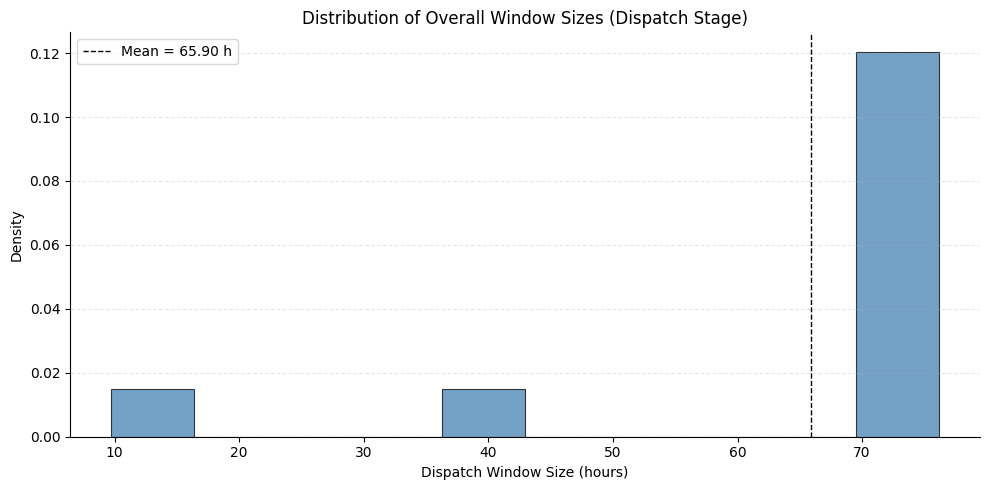

In [2142]:
evaluate_dispatch_window_size(
    stage=Stage.DISPATCH,
    estimation_responses=dispatch_estimation_responses,
    results=results
)

##### Window signed error 

Estimations inside time window: 5/10 (50.00%)
Window estimation advance errors:
	count: 4
	mean: 35.53990825103308
	median: 40.68157491769975
	std: 11.265606458992293
	min: 18.723241584366413
	max: 42.073241584366414
Window estimation delay errors:
	count: 1
	mean: 290.16638758311217
	median: 290.16638758311217
	std: 0.0
	min: 290.16638758311217
	max: 290.16638758311217


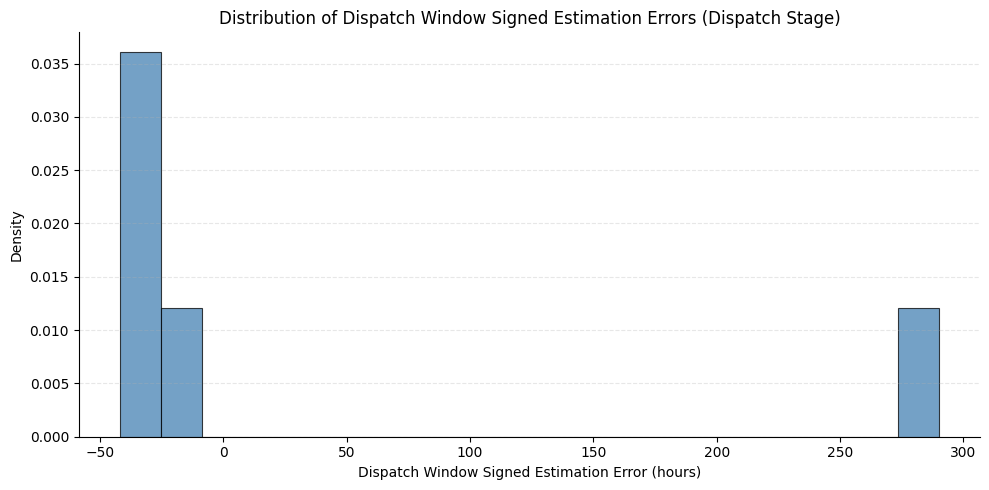

In [2143]:
evaluate_dispatch_window_signed_predictions(
    stage=Stage.DISPATCH,
    estimation_responses=dispatch_estimation_responses,
    order_ids=dispatch_order_ids,
    orders_df=orders_df,
    results=results
    )

##### Window absolute error

Window estimation absolute errors:
	count: 5
	mean: 86.4652041174489
	median: 41.77324158436642
	std: 102.22373192982775
	min: 18.723241584366413
	max: 290.16638758311217


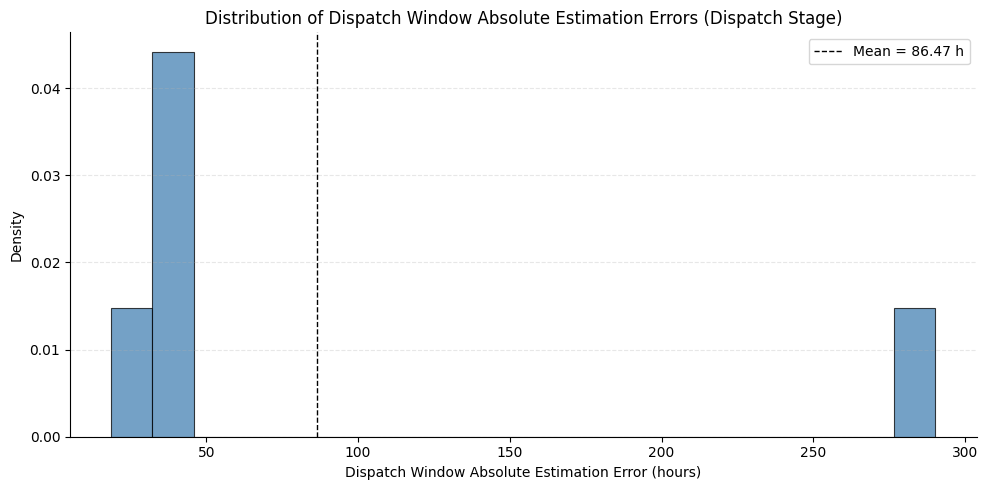

In [2144]:
evaluate_dispatch_window_absolute_predictions(
    stage=Stage.DISPATCH,
    estimation_responses=dispatch_estimation_responses,
    order_ids=dispatch_order_ids,
    orders_df=orders_df,
    results=results
)


#### Shipment

##### Window size

Shipment window sizes for dispatch stage:
	Count: 10
	Mean: 68.98370504502668
	Median: 70.20150629378337
	Std: 7.453341311072384
	Min: 49.26916694999998
	Max: 78.95583314999996


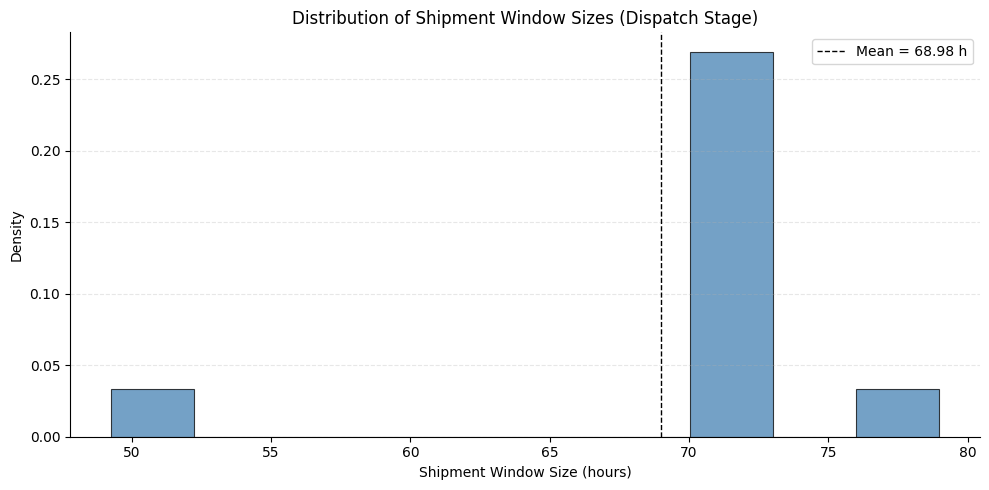

In [2145]:
evaluate_shipment_window_size(
    stage=Stage.DISPATCH,
    estimation_responses=dispatch_estimation_responses,
    results=results
)

##### Window signed error 

Shipment estimations inside time window: 8/10 (80.00%)
Shipment window estimation advance errors:
	count: 0
	mean: 0.0
	median: 0.0
	std: 0.0
	min: 0.0
	max: 0.0
Shipment window estimation delay errors:
	count: 2
	mean: 39.61409184914199
	median: 39.61409184914199
	std: 55.7010528401147
	min: 0.22749966666668797
	max: 79.0006840316173


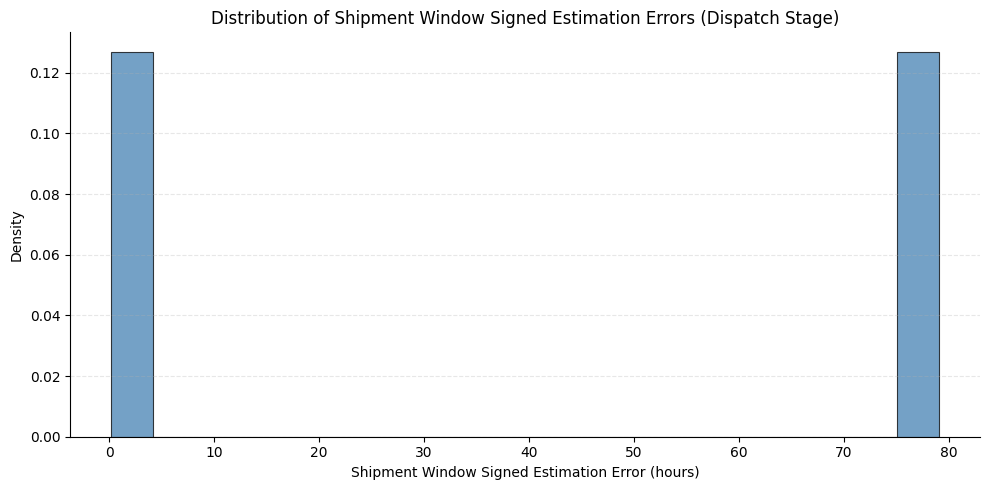

In [2146]:
evaluate_shipment_window_signed_predictions(
    stage=Stage.DISPATCH,
    estimation_responses=dispatch_estimation_responses,
    order_ids=dispatch_order_ids,
    orders_df=orders_df,
    results=results
    )

##### Window absolute error

Shipment window estimation absolute errors:
	count: 2
	mean: 39.61409184914199
	median: 39.61409184914199
	std: 39.386592182475304
	min: 0.22749966666668797
	max: 79.0006840316173


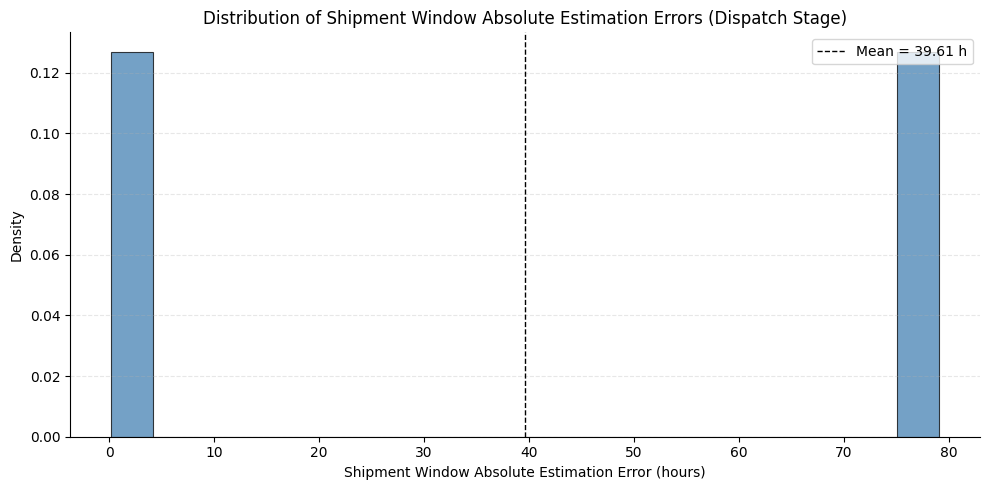

In [2147]:
evaluate_shipment_window_absolute_predictions(
    stage=Stage.DISPATCH,
    estimation_responses=dispatch_estimation_responses,
    order_ids=dispatch_order_ids,
    orders_df=orders_df,
    results=results
)

#### Overall

##### Window size

Overall window sizes for dispatch stage:
	Count: 10
	Mean: 68.98370504502668
	Median: 70.20150629378335
	Std: 7.453341311072382
	Min: 49.26916694999998
	Max: 78.95583314999996


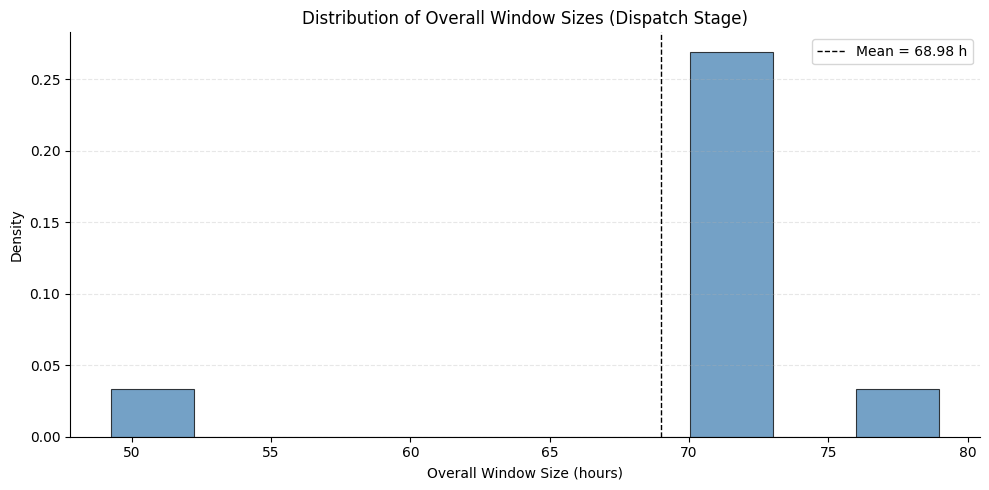

In [2148]:
evaluate_overall_window_size(
    stage=Stage.DISPATCH,
    estimation_responses=dispatch_estimation_responses,
    results=results
)

##### Window signed error 

Estimations inside time window: 3/10 (30.00%)
Overall window estimation advance errors:
	count: 4
	mean: 26.24484019821045
	median: 31.274006864877116
	std: 11.397988573363216
	min: 9.257340198210457
	max: 33.17400686487712
Overall window estimation delay errors:
	count: 3
	mean: 142.85882433867081
	median: 90.24115350800619
	std: 163.59785069553138
	min: 12.044166000000018
	max: 326.2911535080062


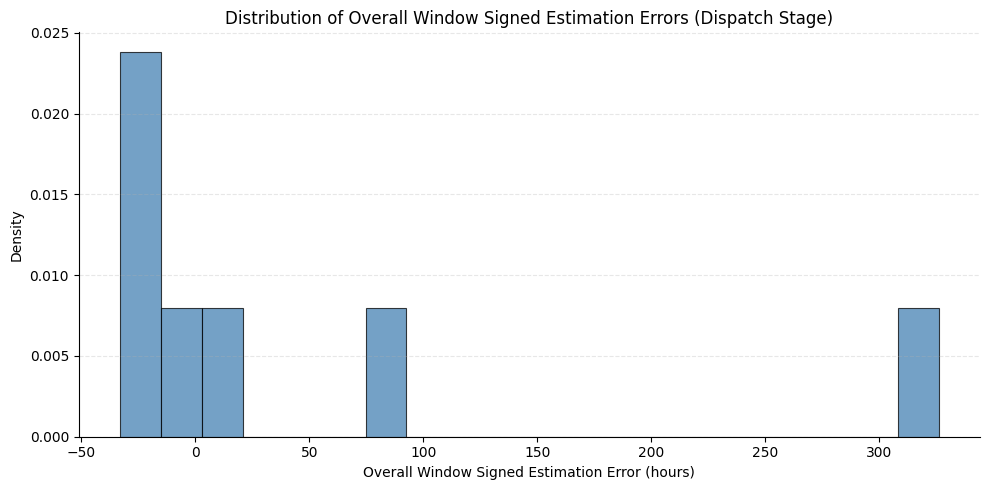

In [2149]:
evaluate_overall_window_signed_predictions(
    stage=Stage.DISPATCH,
    estimation_responses=dispatch_estimation_responses,
    order_ids=dispatch_order_ids,
    orders_df=orders_df,
    results=results
    )

##### Window absolute error

Window estimation absolute errors:
	count: 7
	mean: 76.22226197269346
	median: 32.40734019821045
	std: 105.03776260789869
	min: 9.257340198210457
	max: 326.2911535080062


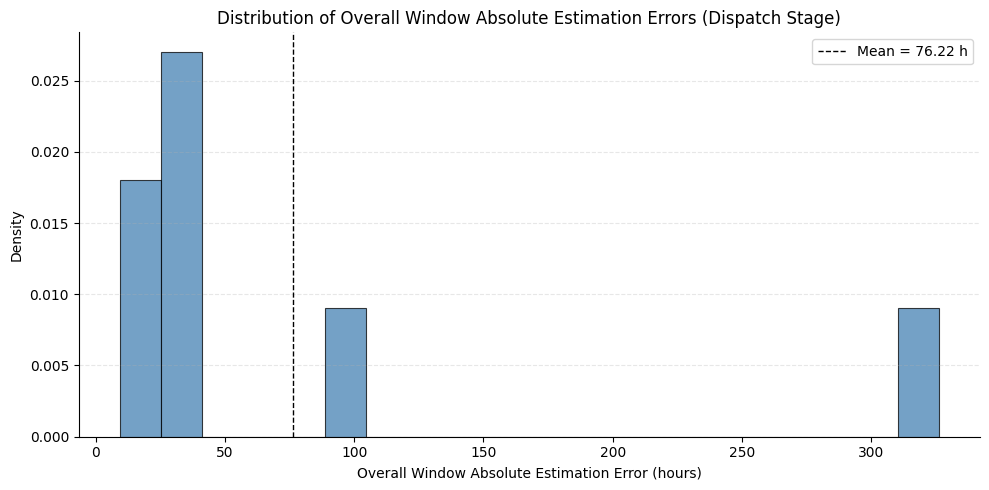

In [2150]:
evaluate_overall_window_absolute_predictions(
    stage=Stage.DISPATCH,
    estimation_responses=dispatch_estimation_responses,
    order_ids=dispatch_order_ids,
    orders_df=orders_df,
    results=results
)

In [2151]:
with open(RESULTS_FILEPATH, "w") as f:
    json.dump(results, f, indent=4)

### Shipment Stage

In [2152]:
results[Stage.SHIPMENT.value]['order_ids'] = shipment_validated_order_ids

#### Dispatch

##### Window size

Dispatch window sizes for shipment stage:
	Count: 106
	Mean: 0.0
	Median: 0.0
	Std: 0.0
	Min: 0.0
	Max: 0.0


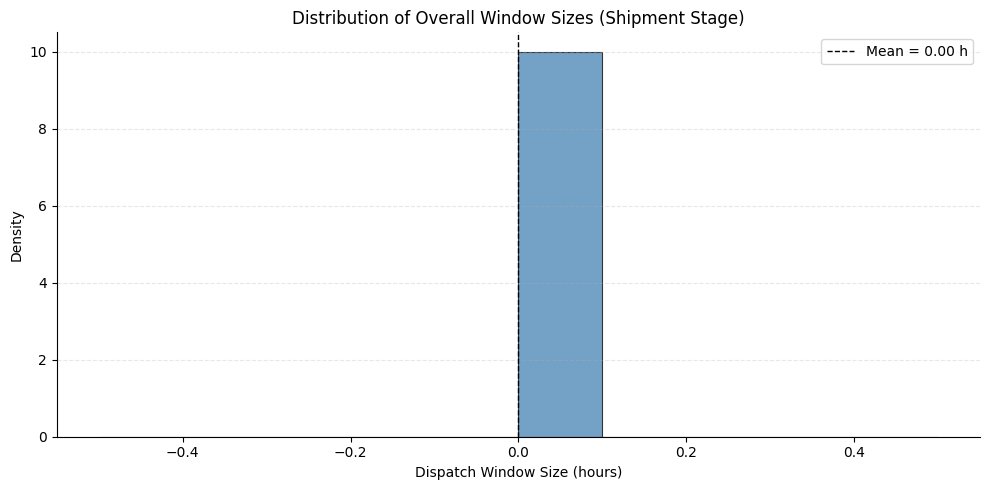

In [2153]:
evaluate_dispatch_window_size(
    stage=Stage.SHIPMENT,
    estimation_responses=shipment_estimation_responses,
    results=results
)

#### Shipment

##### Window size

Shipment window sizes for shipment stage:
	Count: 106
	Mean: 26.7539006271646
	Median: 11.006072318675432
	Std: 26.272039588080673
	Min: 2.9734774163532265
	Max: 78.95583314999996


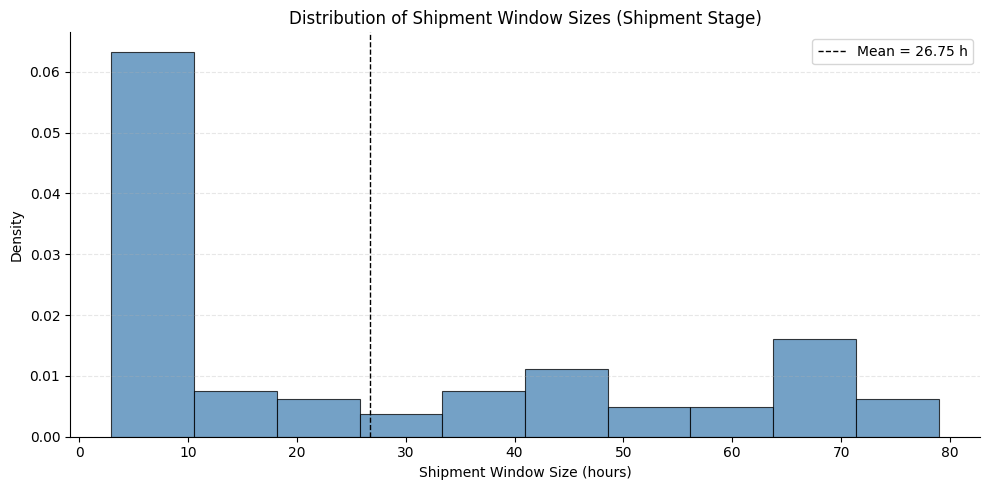

In [2154]:
evaluate_shipment_window_size(
    stage=Stage.SHIPMENT,
    estimation_responses=shipment_estimation_responses,
    results=results
)

##### Window signed error 

Shipment estimations inside time window: 33/106 (31.13%)
Shipment window estimation advance errors:
	count: 0
	mean: 0.0
	median: 0.0
	std: 0.0
	min: 0.0
	max: 0.0
Shipment window estimation delay errors:
	count: 73
	mean: 55.102424692845304
	median: 54.26080290343907
	std: 41.234220283492995
	min: 0.22749966666668797
	max: 174.09846211632717


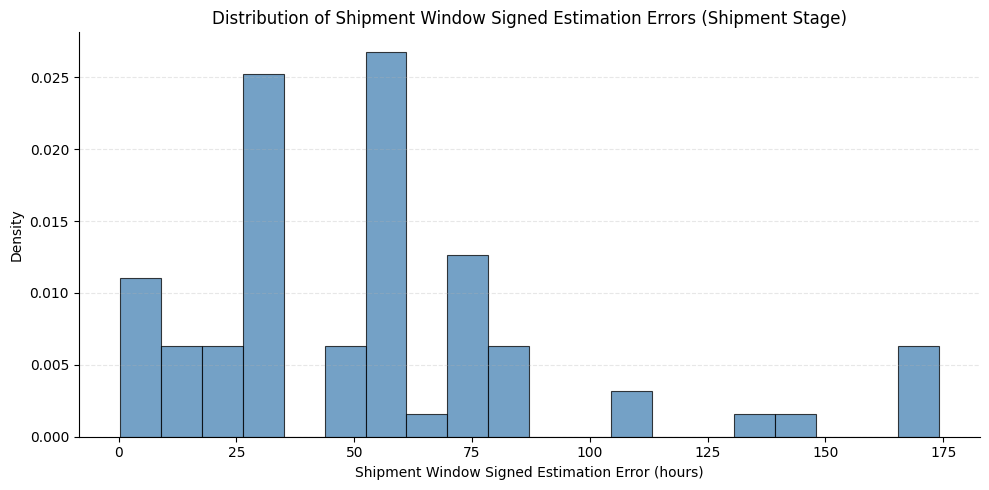

In [2155]:
evaluate_shipment_window_signed_predictions(
    stage=Stage.SHIPMENT,
    estimation_responses=shipment_estimation_responses,
    order_ids=shipment_validated_order_ids,
    orders_df=orders_df,
    results=results
    )

##### Window absolute error

Shipment window estimation absolute errors:
	count: 73
	mean: 55.102424692845304
	median: 54.26080290343907
	std: 40.9508202222552
	min: 0.22749966666668797
	max: 174.09846211632717


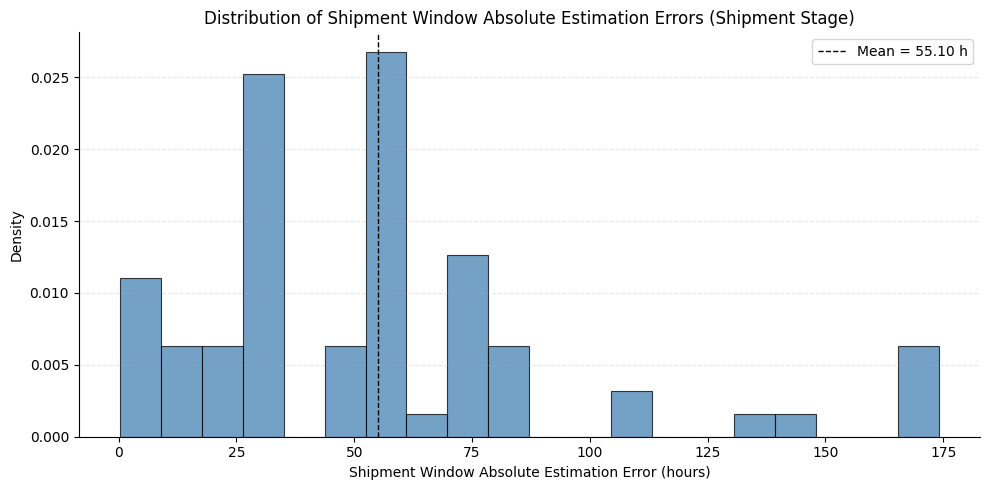

In [2156]:
evaluate_shipment_window_absolute_predictions(
    stage=Stage.SHIPMENT,
    estimation_responses=shipment_estimation_responses,
    order_ids=shipment_validated_order_ids,
    orders_df=orders_df,
    results=results
)

#### Overall

##### Window size

Overall window sizes for shipment stage:
	Count: 106
	Mean: 26.753900627164608
	Median: 11.006072318675415
	Std: 26.272039588080677
	Min: 2.9734774163532336
	Max: 78.95583314999998


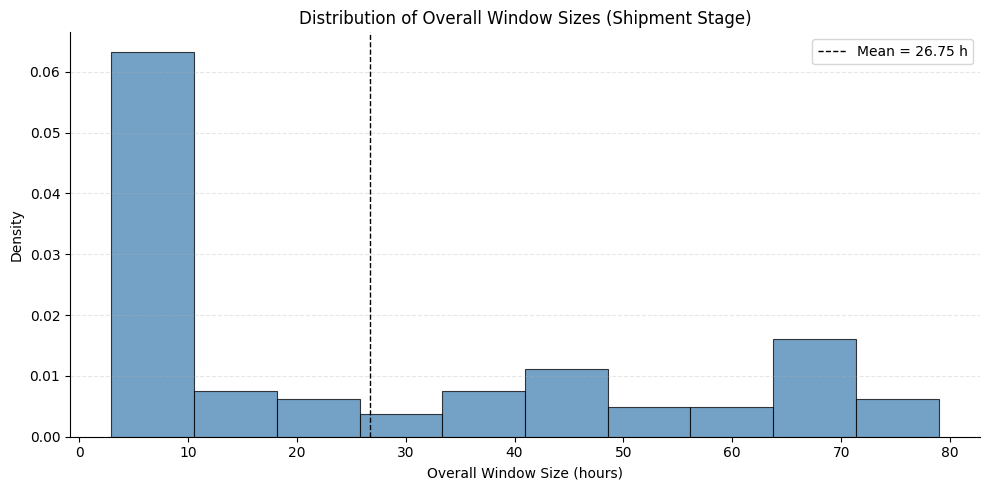

In [2157]:
evaluate_overall_window_size(
    stage=Stage.SHIPMENT,
    estimation_responses=shipment_estimation_responses,
    results=results
)

##### Window signed error 

Estimations inside time window: 47/106 (44.34%)
Overall window estimation advance errors:
	count: 19
	mean: 9.629717700251131
	median: 7.427694872819998
	std: 7.208578604129151
	min: 0.2743747726020871
	max: 19.897809846453356
Overall window estimation delay errors:
	count: 40
	mean: 18.377822043155454
	median: 3.1537412562943032
	std: 31.490709298242578
	min: 0.2122908664256613
	max: 118.33980853330874


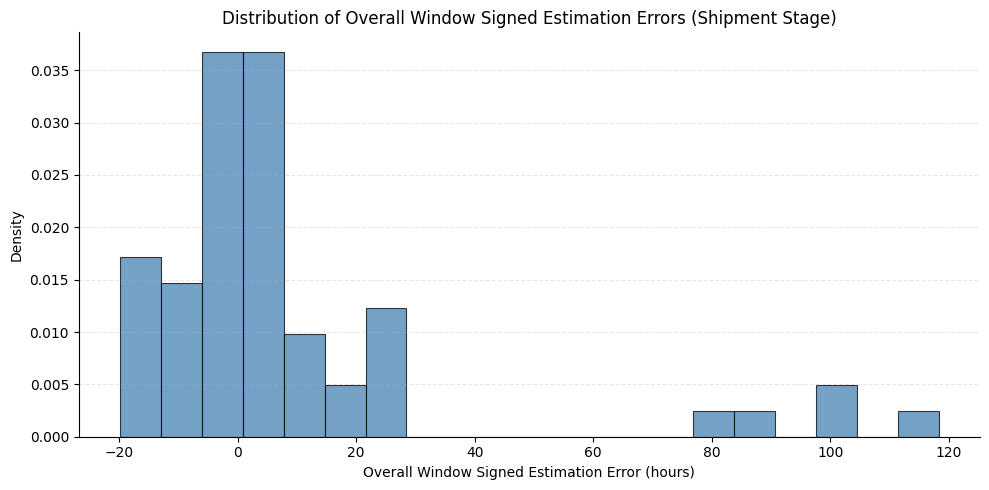

In [2158]:
evaluate_overall_window_signed_predictions(
    stage=Stage.SHIPMENT,
    estimation_responses=shipment_estimation_responses,
    order_ids=shipment_validated_order_ids,
    orders_df=orders_df,
    results=results
    )

##### Window absolute error

Window estimation absolute errors:
	count: 59
	mean: 15.560635898830334
	median: 6.560642245643905
	std: 26.231069863473238
	min: 0.2122908664256613
	max: 118.33980853330874


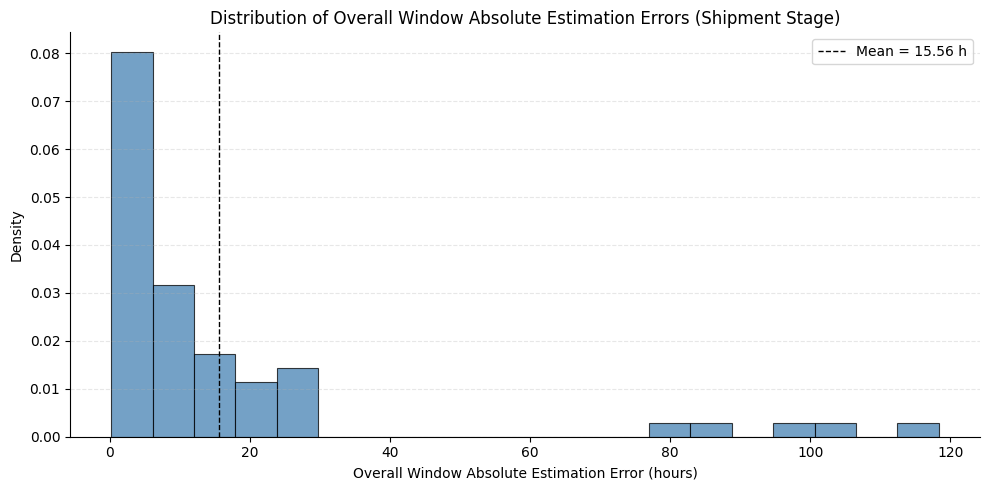

In [2159]:
evaluate_overall_window_absolute_predictions(
    stage=Stage.SHIPMENT,
    estimation_responses=shipment_estimation_responses,
    order_ids=shipment_validated_order_ids,
    orders_df=orders_df,
    results=results
)

In [2160]:
with open(RESULTS_FILEPATH, "w") as f:
    json.dump(results, f, indent=4)

### Delivery Stage

In [2161]:
results[Stage.DELIVERY.value]['order_ids'] = delivery_order_ids

#### Dispatch

##### Window size

Dispatch window sizes for delivery stage:
	Count: 10
	Mean: 0.0
	Median: 0.0
	Std: 0.0
	Min: 0.0
	Max: 0.0


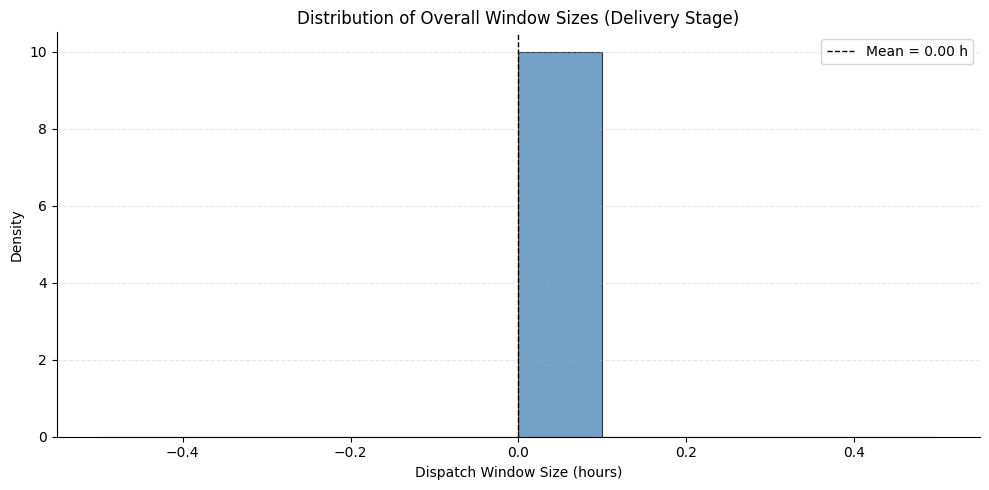

In [2162]:
evaluate_dispatch_window_size(
    stage=Stage.DELIVERY,
    estimation_responses=delivery_estimation_responses,
    results=results
)

#### Shipment

##### Window size

Shipment window sizes for delivery stage:
	Count: 10
	Mean: 0.0
	Median: 0.0
	Std: 0.0
	Min: 0.0
	Max: 0.0


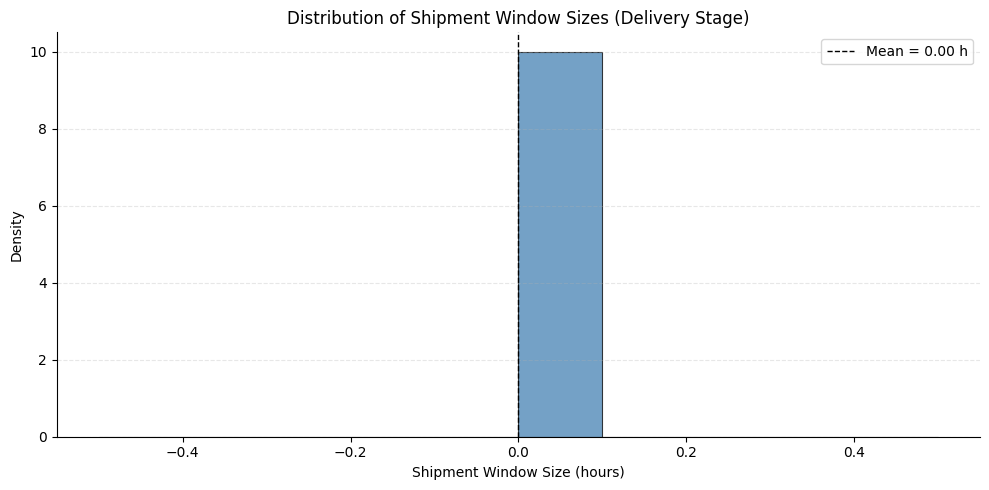

In [2163]:
evaluate_shipment_window_size(
    stage=Stage.DELIVERY,
    estimation_responses=delivery_estimation_responses,
    results=results
)

##### Window signed error 

Shipment estimations inside time window: 0/10 (0.00%)
Shipment window estimation advance errors:
	count: 0
	mean: 0.0
	median: 0.0
	std: 0.0
	min: 0.0
	max: 0.0
Shipment window estimation delay errors:
	count: 10
	mean: 78.36166666666666
	median: 66.33333333333334
	std: 40.43242575543961
	min: 37.21666666666667
	max: 182.26666666666668


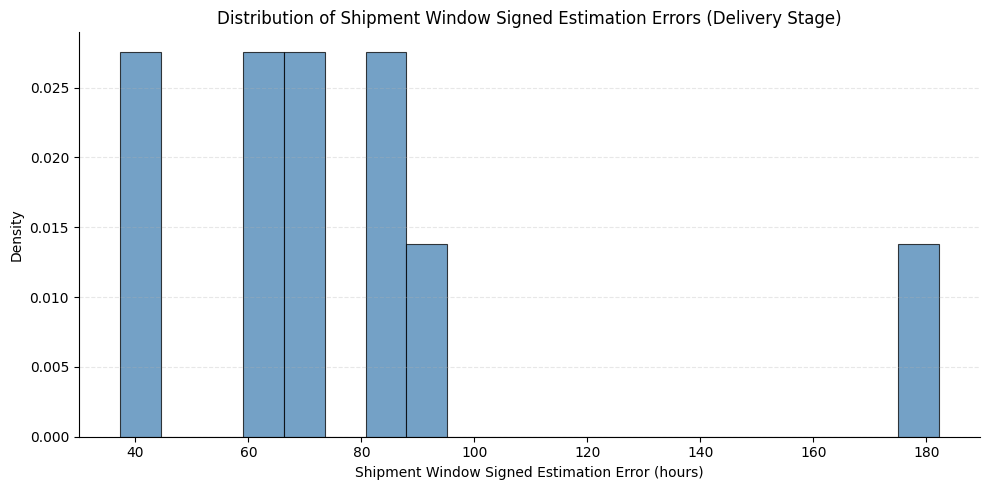

In [2164]:
evaluate_shipment_window_signed_predictions(
    stage=Stage.DELIVERY,
    estimation_responses=delivery_estimation_responses,
    order_ids=delivery_validated_order_ids,
    orders_df=orders_df,
    results=results
    )

##### Window absolute error

Shipment window estimation absolute errors:
	count: 10
	mean: 78.36166666666666
	median: 66.33333333333334
	std: 38.357567013852986
	min: 37.21666666666667
	max: 182.26666666666668


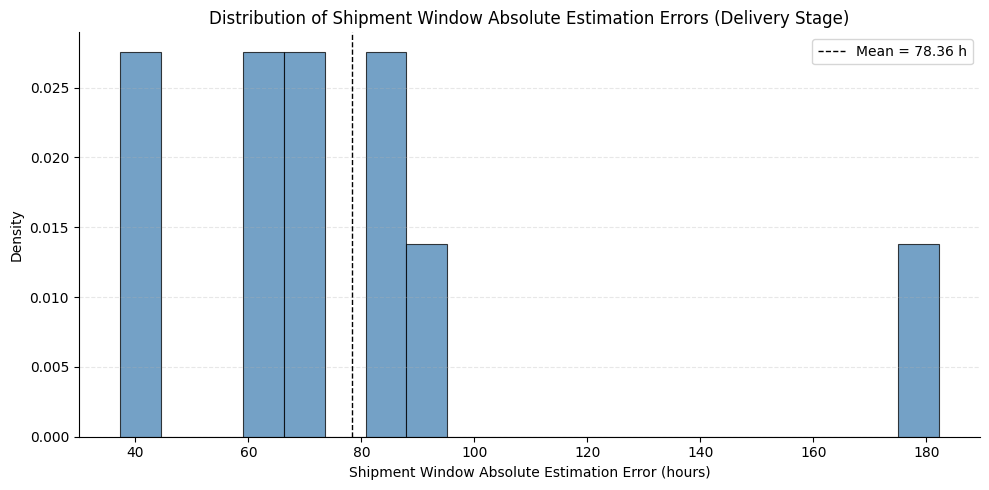

In [2165]:
evaluate_shipment_window_absolute_predictions(
    stage=Stage.DELIVERY,
    estimation_responses=delivery_estimation_responses,
    order_ids=delivery_validated_order_ids,
    orders_df=orders_df,
    results=results
)

#### Overall

##### Window size

Overall window sizes for delivery stage:
	Count: 10
	Mean: 0.0
	Median: 0.0
	Std: 0.0
	Min: 0.0
	Max: 0.0


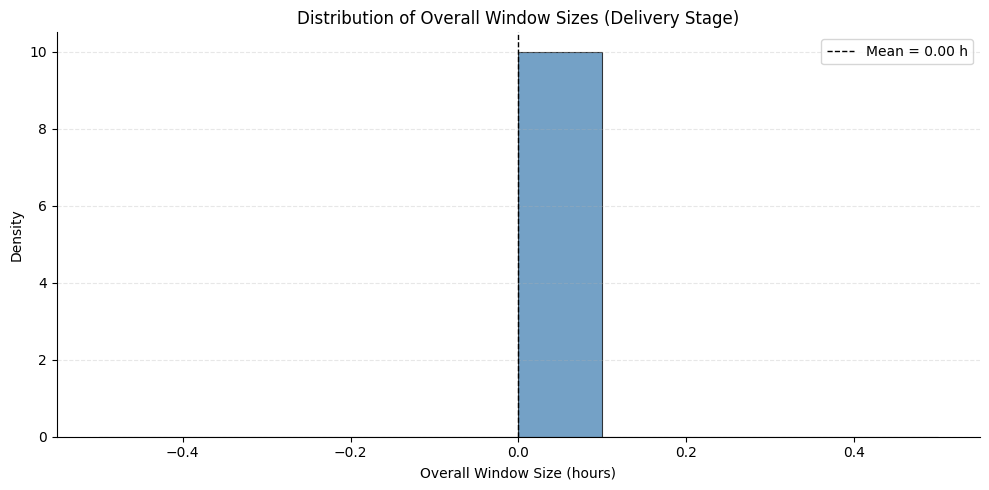

In [2166]:
evaluate_overall_window_size(
    stage=Stage.DELIVERY,
    estimation_responses=delivery_estimation_responses,
    results=results
)

##### Window signed error 

Estimations inside time window: 8/10 (80.00%)
Overall window estimation advance errors:
	count: 1
	mean: 2.842170943040401e-14
	median: 2.842170943040401e-14
	std: 0.0
	min: 2.842170943040401e-14
	max: 2.842170943040401e-14
Overall window estimation delay errors:
	count: 1
	mean: 2.842170943040401e-14
	median: 2.842170943040401e-14
	std: 0.0
	min: 2.842170943040401e-14
	max: 2.842170943040401e-14


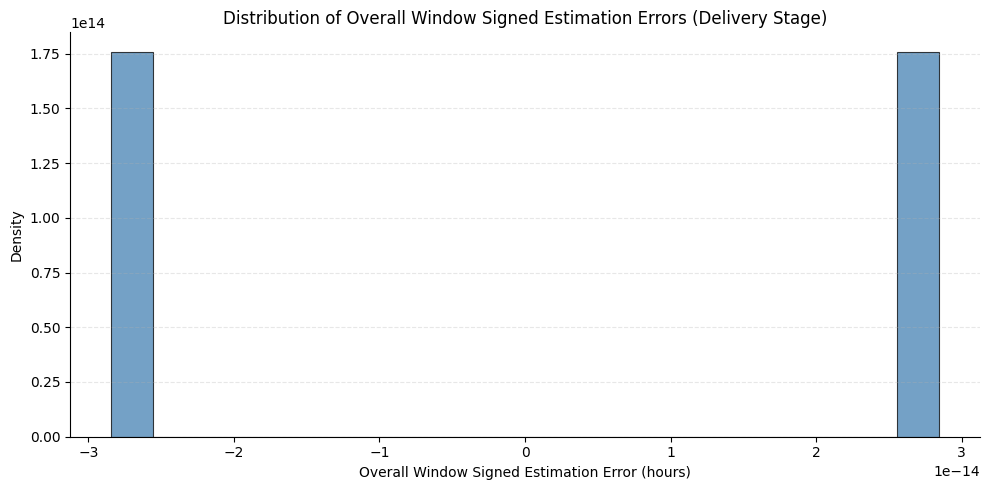

In [2167]:
evaluate_overall_window_signed_predictions(
    stage=Stage.DELIVERY,
    estimation_responses=delivery_estimation_responses,
    order_ids=delivery_validated_order_ids,
    orders_df=orders_df,
    results=results
    )

##### Window absolute error

Window estimation absolute errors:
	count: 2
	mean: 2.842170943040401e-14
	median: 2.842170943040401e-14
	std: 0.0
	min: 2.842170943040401e-14
	max: 2.842170943040401e-14


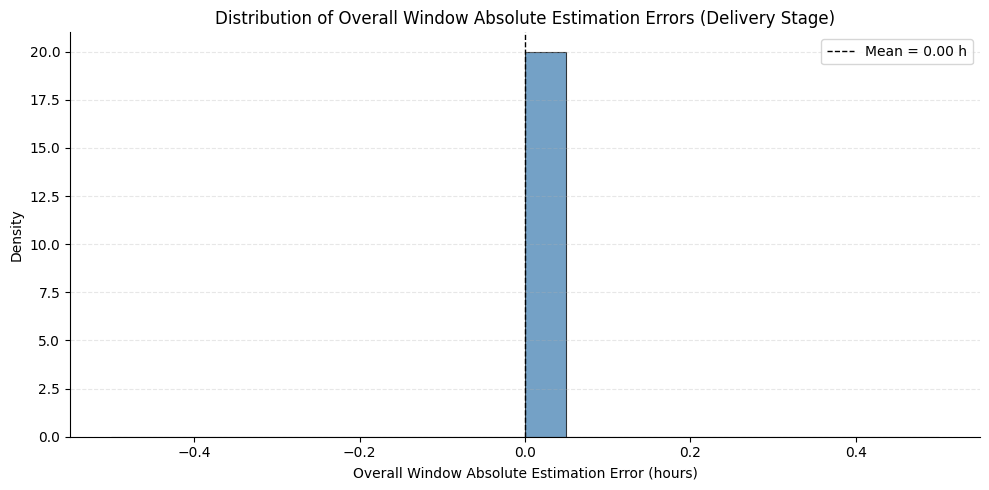

In [2168]:
evaluate_overall_window_absolute_predictions(
    stage=Stage.DELIVERY,
    estimation_responses=delivery_estimation_responses,
    order_ids=delivery_validated_order_ids,
    orders_df=orders_df,
    results=results
)

In [2169]:
with open(RESULTS_FILEPATH, "w") as f:
    json.dump(results, f, indent=4)

## Case Study

### Estimation evolution during order steps

#### Data preparation

In [2170]:
CASE_STUDY_PATH = f"{DATASET_PATH}/case_study"
if not os.path.exists(CASE_STUDY_PATH):
    os.makedirs(CASE_STUDY_PATH)

In [2171]:
sites_df.head()

,id,supplier_id,location_name,n_rejections,n_orders,consider_closure_holidays,consider_working_holidays,consider_weekends_holidays
0,1,1,"LEEDS, ENGLAND, GB",0,5,True,True,True
1,2,2,"LOUISVILLE, KENTUCKY, US",0,3,True,True,True
2,3,2,"THIEF RIVER FALLS, MINNESOTA, US",0,61,True,True,True
3,4,3,"GRAND PRAIRIE, TEXAS, US",0,5,True,True,True
4,5,4,"MONTAGNOLA, TICINO, CH",0,1,True,True,True


In [2172]:
order_ids_by_site: Dict[int, List[int]] = defaultdict(list)
for i, row in orders_df.iterrows():
    site_id: int = row["site_id"]
    order_id: int = row["id"]
    order_ids_by_site[site_id].append(order_id)

order_ids_by_site.keys(), order_ids_by_site.values()

(dict_keys([3, 1, 4]),
 dict_values([[44, 72, 96, 84, 54, 100, 60, 93], [20], [12]]))

In [2173]:
sample_site_ids: List[int] = [1, 3, 3, 3, 4]        # Three orders from site 3

RANDOM_SEED = 43
random.seed(RANDOM_SEED)

sample_order_ids: List[int] = [random.choice(order_ids_by_site[site_id]) for site_id in sample_site_ids]
sample_order_df: pd.DataFrame = orders_df[orders_df["id"].isin(sample_order_ids)]
sample_order_df

,id,manufacturer_id,manufacturer_order_id,site_id,carrier_id,status,n_steps,tracking_link,tracking_number,manufacturer_creation_timestamp,manufacturer_estimated_delivery_timestamp,manufacturer_confirmed_delivery_timestamp,carrier_creation_timestamp,carrier_estimated_delivery_timestamp,carrier_confirmed_delivery_timestamp,SLS,SRS
2,96,1,8008,3,2,DELIVERED,12,https://www.ups.com/track?tracknum=1ZR46591041...,1ZR465910413364539,2025-07-04 13:42:00+00:00,2025-07-06 20:00:00+00:00,2025-07-12 06:26:00+00:00,2025-07-07 19:17:00+00:00,NaN,2025-07-10 13:43:00+00:00,0,0
3,20,1,6194,1,2,DELIVERED,11,https://www.ups.com/track?tracknums_displayed=...,1Z60699Y0401145407,2025-01-31 14:08:00+00:00,2025-02-02 22:00:00+00:00,2025-02-03 10:00:00+00:00,2025-01-31 19:03:00+00:00,NaN,2025-02-03 09:50:00+00:00,0,0
5,54,1,7357,3,2,DELIVERED,12,https://www.ups.com/track?tracknum=1ZR46591041...,1ZR465910413316617,2025-05-09 11:10:00+00:00,2025-05-12 20:00:00+00:00,2025-05-16 04:47:00+00:00,2025-05-09 19:07:00+00:00,NaN,2025-05-12 13:21:00+00:00,0,0
7,12,1,6121,4,3,DELIVERED,12,https://www.fedex.com/fedextrack/?trknbr=43925...,439256767958,2025-01-23 15:59:00+00:00,2025-01-27 22:00:00+00:00,2025-01-28 11:58:00+00:00,2025-01-24 23:07:00+00:00,NaN,2025-01-28 11:50:00+00:00,0,0
9,93,1,7942,3,2,DELIVERED,11,https://www.ups.com/track?tracknum=1ZR46591041...,1ZR465910413361729,2025-07-01 10:41:00+00:00,2025-07-03 20:00:00+00:00,2025-07-15 07:08:00+00:00,2025-07-02 23:27:00+00:00,NaN,2025-07-10 13:43:00+00:00,0,0


In [2174]:
sample_order_steps_enriched_df: pd.DataFrame = order_steps_enriched_df[order_steps_enriched_df["order_id"].isin(sample_order_ids)]
sample_order_steps_enriched_df.shape

(53, 9)

In [2175]:
requests_body: List[Dict[str, Any]] = []
order_ids: List[int] = []

for i, row in sample_order_steps_enriched_df.iterrows():
    order_row: pd.Series = sample_order_df[sample_order_df["id"] == row["order_id"]].iloc[0]
    order_id: int = order_row["id"]

    site_id: int = int(order_row["site_id"])
    carrier_id: int = int(order_row["carrier_id"])

    order_time: datetime = pd.to_datetime(order_row["manufacturer_creation_timestamp"])
    shipment_time: datetime = pd.to_datetime(order_row["carrier_creation_timestamp"])
    delivery_time: datetime = pd.to_datetime(order_row['carrier_confirmed_delivery_timestamp'])

    step_source: int = row["step_source"]
    step_destination: int = row["step_destination"]

    if step_source == 1:
        vertex_name: str = str(site_id)
        vertex_type: str = "SUPPLIER_SITE"
        requests_body.append(create_estimation_request_body(            # Estimation for when the order is still in dispatch
            vertex_name=vertex_name,
            vertex_type=vertex_type,
            site_id=site_id,
            carrier_id=carrier_id,
            order_time=order_time,
            event_time=order_time,
            estimation_time=order_time,
        ))
        order_ids.append(int(order_id))
    else:
        vertex_name: str = row["location_source"]
        vertex_type: str = "INTERMEDIATE"

    event_time: datetime = pd.to_datetime(row["timestamp_source"])
    estimation_time: datetime = event_time

    request_body: Dict[str, Any] = create_estimation_request_body(      # Estimation for the carrier event
        vertex_name=vertex_name,
        vertex_type=vertex_type,
        site_id=site_id,
        carrier_id=carrier_id,
        order_time=order_time,
        maybe_shipment_time=shipment_time,
        event_time=event_time,
        estimation_time=estimation_time,
    )
    requests_body.append(request_body)
    order_ids.append(int(order_id))
    
    if step_destination == order_row["n_steps"]:
        requests_body.append(create_estimation_request_body(            # Estimation for the last event (delivery to the manufacturer)
            vertex_name=manufacturer_name,
            vertex_type="MANUFACTURER",
            site_id=site_id,
            carrier_id=carrier_id,
            order_time=order_time,
            maybe_shipment_time=shipment_time,
            event_time=pd.to_datetime(row['timestamp_destination']),
            estimation_time=pd.to_datetime(row['timestamp_destination']),
        ))
        order_ids.append(int(order_id))
        
len(requests_body), len(order_ids)

(63, 63)

In [2176]:
assert len(requests_body) == len(order_ids), "Mismatch between number of requests and order IDs"
assert len(requests_body) == len(sample_order_steps_enriched_df) + 2 * len(sample_order_df)

In [2177]:
delivery_time_by_order: Dict[int, float] = {}
for i, row in sample_order_df.iterrows():
    order_id: int = row["id"]
    order_time: datetime = pd.to_datetime(row["manufacturer_creation_timestamp"])
    delivery_time: datetime = pd.to_datetime(row["carrier_confirmed_delivery_timestamp"])
    delivery_time_by_order[order_id] = (delivery_time - order_time).total_seconds() / 3600  # Convert to hours

delivery_time_by_order

{96: 144.01666666666668,
 20: 67.7,
 54: 74.18333333333334,
 12: 115.85,
 93: 219.03333333333333}

#### Estimation computation

In [2178]:
warm_lambda()

In [2179]:
CHUNK_SIZE = 2
MAX_WORKERS = 10

chunks = list(chunked(requests_body, CHUNK_SIZE))
assert CHUNK_SIZE * (len(chunks) - 1) + len(chunks[-1]) == len(requests_body)
len(chunks)

32

In [2180]:
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    estimations_chunked = list(executor.map(execute_chunk_estimation, chunks, list(range(len(chunks)))))

len(estimations_chunked)

Processing chunk 0 of size: 2
Processing chunk 1 of size: 2
Processing chunk 2 of size: 2
Processing chunk 3 of size: 2
Processing chunk 4 of size: 2
Processing chunk 5 of size: 2
Processing chunk 6 of size: 2
Processing chunk 7 of size: 2
Processing chunk 8 of size: 2
Processing chunk 9 of size: 2
	Chunk 7 processed in 1.22 seconds
Processing chunk 10 of size: 2
	Chunk 6 processed in 1.25 seconds
Processing chunk 11 of size: 2
	Chunk 1 processed in 1.27 seconds
Processing chunk 12 of size: 2
	Chunk 0 processed in 1.69 seconds
Processing chunk 13 of size: 2
	Chunk 12 processed in 1.11 seconds
Processing chunk 14 of size: 2
	Chunk 8 processed in 4.40 seconds
Processing chunk 15 of size: 2
	Chunk 11 processed in 3.20 seconds
Processing chunk 16 of size: 2
	Chunk 4 processed in 4.53 seconds
Processing chunk 17 of size: 2
	Chunk 5 processed in 4.59 seconds
Processing chunk 18 of size: 2
	Chunk 10 processed in 4.05 seconds
Processing chunk 19 of size: 2
	Chunk 9 processed in 6.00 seconds
Pr

32

In [2181]:
estimations: List[Dict[str, Any]] = []
for chunk in estimations_chunked:
    assert isinstance(chunk, list), "Each chunk should be a list of estimations"
    estimations.extend(chunk)

assert len(estimations) == len(requests_body) == sum(len(chunk) for chunk in estimations_chunked), "Total number of estimations does not match the number of requests"

len(estimations)

63

In [2182]:
estimation_by_order: Dict[int, List[Dict[str, Any]]] = defaultdict(list)

assert isinstance(estimations, list), "Response should be a list of estimations"
for order_id, estimation in zip(order_ids, estimations):
    estimation_by_order[order_id].append(estimation)

with open(f"{CASE_STUDY_PATH}/estimation_by_order.json", "w") as f:
    json.dump(estimation_by_order, f, indent=4)

len(estimation_by_order)

5

In [2183]:
with open(f"{CASE_STUDY_PATH}/estimation_by_order.json", "r") as f:
    estimation_by_order = json.load(f)

len(estimation_by_order)

5

#### Plots

In [2184]:
def build_step_label(vertex_name: str, vertex_type: str, step: int) -> str:
    if vertex_type == "SUPPLIER_SITE":
        return f"{vertex_name} ({vertex_type})\n$t_{{ {step} }}$"
    elif vertex_type == "INTERMEDIATE":
        city, state, country = vertex_name.split(", ")
        return f"{city}, {country}\n$t_{{ {step} }}$"
    elif vertex_type == "MANUFACTURER":
        return f"{vertex_name} ({vertex_type})\n$t_{{ {step} }}$"
    else:
        raise ValueError(f"Unknown vertex type: {vertex_type}")

##### Time estimates

In [2185]:
def plot_order_estimation_evolution(order_id: int, estimation_by_order: Dict[str, List[Dict[str, Any]]], delivery_time_by_order: Dict[int, float]) -> None:
    estimation_l_bounds_data: List[float] = []
    estimation_u_bounds_data: List[float] = []
    estimation_eodt_data: List[float] = []
    estimation_steps: List[str] = []
    cumulated_time_days: List[float] = []

    order_delivery_time_days: float = delivery_time_by_order[order_id] / 24.0

    for i, estimation in enumerate(estimation_by_order[str(order_id)]):
        vertex = estimation["vertex"]
        indicators = estimation["indicators"]

        estimation_steps.append(build_step_label(vertex["name"], vertex["type"], i))

        lb: float = indicators["EODT"] - indicators["CFDI"]["lower"]
        ub: float = indicators["EODT"] + indicators["CFDI"]["upper"]
        eodt: float = indicators["EODT"]

        estimation_l_bounds_data.append(lb / 24.0)
        estimation_u_bounds_data.append(ub / 24.0)
        estimation_eodt_data.append(eodt / 24.0)

        order_creation_time = pd.to_datetime(estimation["order_time"])
        event_time = pd.to_datetime(estimation["event_time"])
        cumulated_days = (event_time - order_creation_time).total_seconds() / 3600.0  # Convert to hours
        cumulated_time_days.append(cumulated_days / 24.0 if i > 0 else 0.0)  # Start from t_0 = 0

    x = range(len(estimation_steps))
    acceptable_lower = math.floor(order_delivery_time_days)
    acceptable_upper = math.ceil(order_delivery_time_days)

    order_delivery_time_dev_days: float = 0.0
    acceptable_lower_dev: float = acceptable_lower - order_delivery_time_days
    acceptable_upper_dev: float = acceptable_upper - order_delivery_time_days
    estimated_l_bounds_dev: np.ndarray = np.array(estimation_l_bounds_data) - order_delivery_time_days
    estimated_u_bounds_dev: np.ndarray = np.array(estimation_u_bounds_data) - order_delivery_time_days
    eodt_dev: np.ndarray = np.array(estimation_eodt_data) - order_delivery_time_days

    fig, ax = plt.subplots(2, 1, figsize=(14, 6), gridspec_kw={'height_ratios': [1.25, 1]})

    # Fill green area for acceptable range (lower to upper)
    ax[0].fill_between(
        x,
        [acceptable_lower_dev] * len(x),
        [acceptable_upper_dev] * len(x),
        color='palegreen',
        alpha=0.3,
        label='Delivery day'
    )

    # Fill blue area for estimation bounds (on top of green)
    ax[0].fill_between(
        x,
        estimated_l_bounds_dev,
        estimated_u_bounds_dev,
        color='skyblue',
        alpha=0.3,
        label='Estimated window'
    )

    # Plot actual delivery time and acceptable bounds
    ax[0].axhline(y=order_delivery_time_dev_days, color='green', linestyle='-', linewidth=2, label='Delivery time', alpha=0.5)

    # Plot estimated bounds
    ax[0].plot(x, estimated_l_bounds_dev, label='CFDI lower', marker='o', linestyle='--', color='blue', alpha=0.2)
    ax[0].plot(x, eodt_dev, label='EODT', marker='o', linestyle='--', color='black')
    ax[0].plot(x, estimated_u_bounds_dev, label='CFDI upper', marker='o', linestyle='--', color='red', alpha=0.2)

    ax[1].plot(x, cumulated_time_days, label='Cumulated Time', marker='o', linestyle='-', color='purple')

    # Axis configuration
    ax[0].set_xticks(x)
    ax[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

    ax[0].set_ylabel('Time Deviation (days)')
    ax[0].legend(bbox_to_anchor=(1.00, 1.03), loc='upper left')
    ax[0].grid(True, alpha=0.3)
    #ax[0].set_ylim(-8, 8)

    ax[1].set_xlabel('Order Steps')
    ax[1].set_ylabel('Time (days)')
    ax[1].legend(loc='lower right')
    ax[1].grid(True, alpha=0.3)

    ax[1].set_xticks(x)
    ax[1].set_xticklabels(estimation_steps, rotation=45, ha='right')
    tick_labels = ax[1].get_xticklabels()
    tick_labels[0].set_color("#AB0C0C")  # First label
    tick_labels[-1].set_color("#3F8314")   # Last label # Steel blue

    fig.text(
        0.865,                        # x position (0 to 1 in figure coordinates)
        0.54,                         # y position (0 to 1)
        f'Delivery Time: {order_delivery_time_days:.1f} days',
        va='center', ha='left',
        bbox=dict(facecolor='white', edgecolor='lightgray', boxstyle='round,pad=0.3')
    )

    fig.suptitle(f'Evolution of Time Estimates across Order Steps – Order {order_id}')
    plt.tight_layout()
    plt.savefig(f"{CASE_STUDY_PATH}/order_{order_id}_estimation_evolution.png", bbox_inches='tight')
    plt.show()

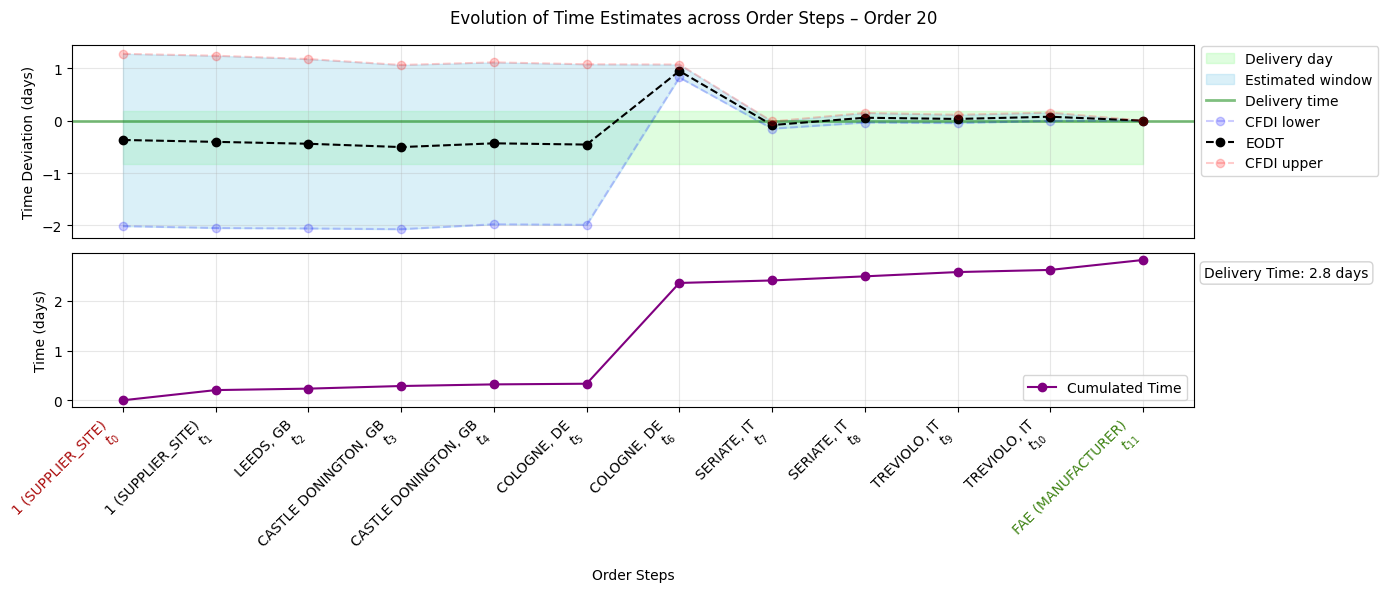

In [2186]:
plot_order_estimation_evolution(order_id=sample_order_ids[0], estimation_by_order=estimation_by_order, delivery_time_by_order=delivery_time_by_order)

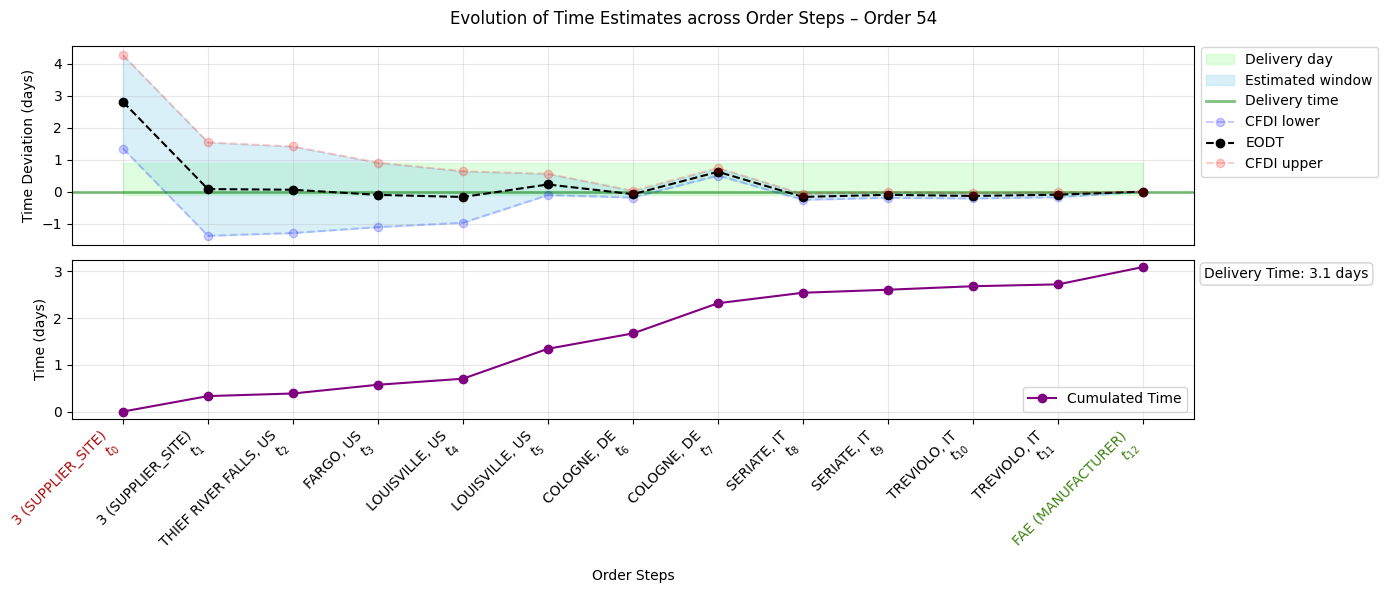

In [2187]:
plot_order_estimation_evolution(order_id=sample_order_ids[1], estimation_by_order=estimation_by_order, delivery_time_by_order=delivery_time_by_order)

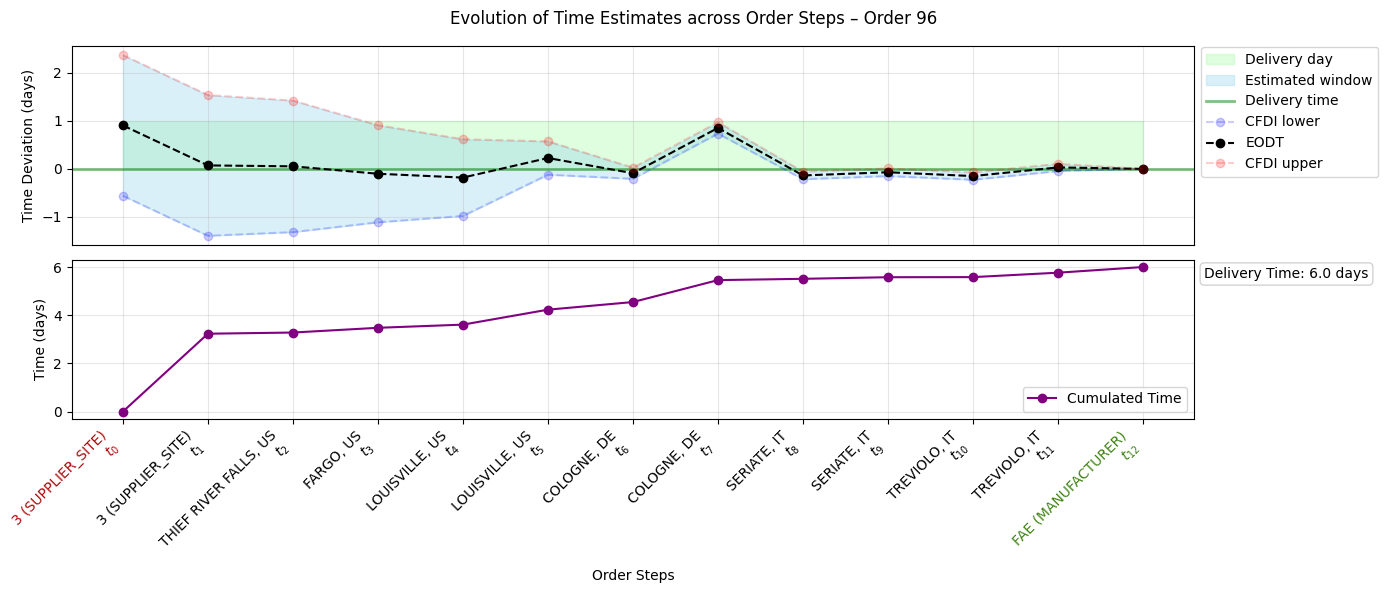

In [2188]:
plot_order_estimation_evolution(order_id=sample_order_ids[2], estimation_by_order=estimation_by_order, delivery_time_by_order=delivery_time_by_order)

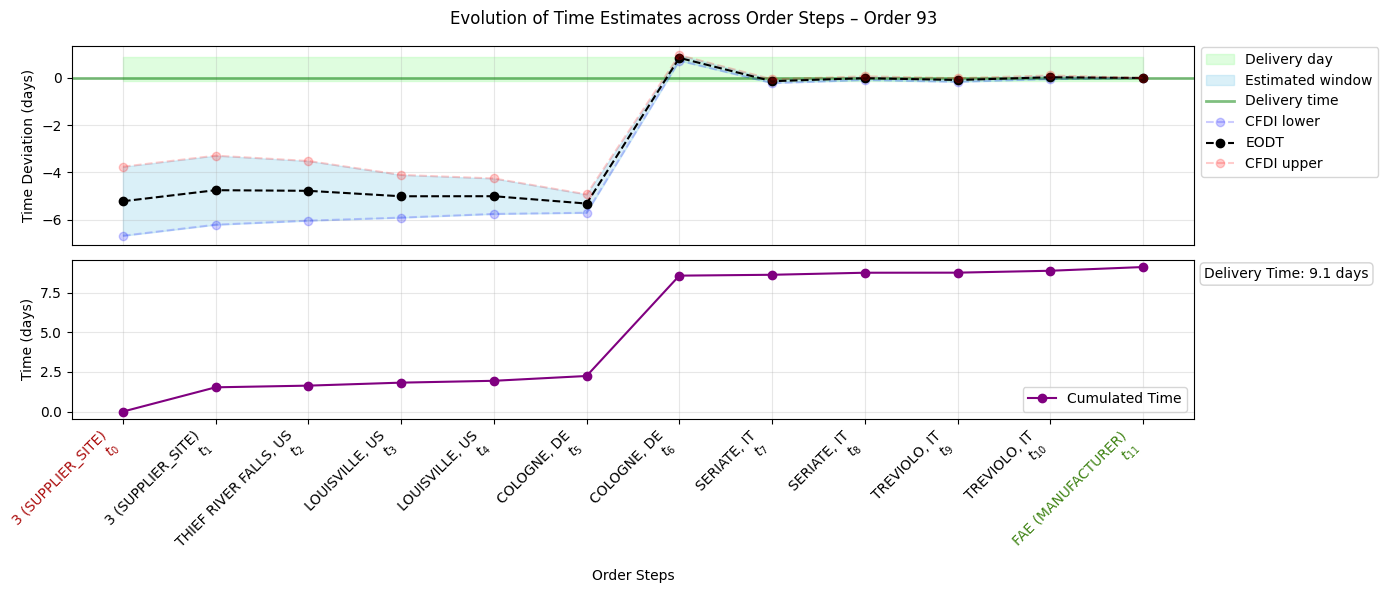

In [2189]:
plot_order_estimation_evolution(order_id=sample_order_ids[3], estimation_by_order=estimation_by_order, delivery_time_by_order=delivery_time_by_order)

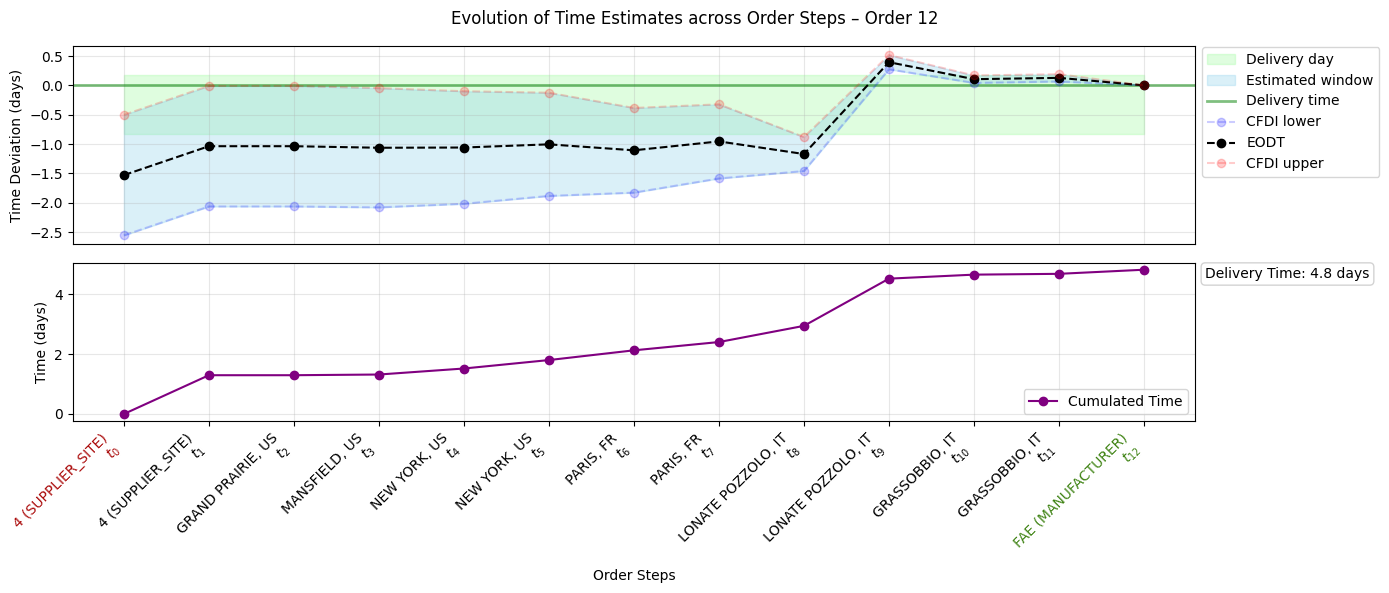

In [2190]:
plot_order_estimation_evolution(order_id=sample_order_ids[4], estimation_by_order=estimation_by_order, delivery_time_by_order=delivery_time_by_order)

##### Delay estimates

In [2191]:
HISTORICAL_API_URL: str = ROOT_URL + "lcdi/historical/"
HISTORICAL_API_URL

'https://rhwompporf.execute-api.eu-central-1.amazonaws.com/dev/lcdi/historical/'

In [2192]:
",".join([HISTORICAL_API_URL, "orders/steps/enriched"])

'https://rhwompporf.execute-api.eu-central-1.amazonaws.com/dev/lcdi/historical/,orders/steps/enriched'

In [2193]:
from typing import Iterable

site_ids: Iterable[str] = [str(orders_df[orders_df["id"] == order_id]["site_id"].values[0]) for order_id in sample_order_ids]
carrier_ids: Iterable[str] = [str(orders_df[orders_df["id"] == order_id]["carrier_id"].values[0]) for order_id in sample_order_ids]

site_qparams: str = ", ".join(site_ids)
carrier_qparams: str = ", ".join(carrier_ids)

site_qparams, carrier_qparams

('1, 3, 3, 3, 4', '2, 2, 2, 2, 3')

In [2194]:
response = requests.get(HISTORICAL_API_URL, params={"site": site_qparams, "carrier": carrier_qparams})
response.raise_for_status()
historical_data: List[Dict[str, Any]] = response.json()

historical_data

[{'site': {'id': 3, 'location': 'THIEF RIVER FALLS, MINNESOTA, US'},
  'supplier': {'id': 2, 'manufacturer_id': 2, 'name': 'DIGIKEY'},
  'carrier': {'id': 2, 'name': 'UPS'},
  'indicators': {'ADT': 25.526197190376998,
   'DDI': {'lower': 23.502955606010584,
    'upper': 52.64074855984412,
    'confidence': 0.9},
   'DRI': 0.0,
   'CLI': 0.0,
   'AST': 56.813989943441,
   'CTDI': {'lower': 23.749513602174986,
    'upper': 46.45199269160838,
    'confidence': 0.9},
   'AODT': 82.340187133818,
   'ODI': {'lower': 47.25246920818557, 'upper': 99.09274125145251}}},
 {'site': {'id': 1, 'location': 'LEEDS, ENGLAND, GB'},
  'supplier': {'id': 1, 'manufacturer_id': 1, 'name': 'FARNELL'},
  'carrier': {'id': 2, 'name': 'UPS'},
  'indicators': {'ADT': 5.783333,
   'DDI': {'lower': 3.6408329999999998,
    'upper': 6.102500049999997,
    'confidence': 0.9},
   'DRI': 0.0,
   'CLI': 0.0,
   'AST': 42.045833,
   'CTDI': {'lower': 28.455833050000003,
    'upper': 50.500000099999966,
    'confidence': 0

In [2195]:
historical_data_by_site_carrier: Dict[Tuple[int, int], Dict[str, Any]] = {}

for doc in historical_data:
    doc: Dict[str, Any]
    site_id: int = doc["site"]["id"]
    carrier_id: int = doc["carrier"]["id"]
    historical_data_by_site_carrier[(site_id, carrier_id)] = doc

assert len(historical_data_by_site_carrier) == len(historical_data)

In [2196]:
historical_data_by_order: Dict[int, Dict[str, Any]] = {}

for order_id, site_id, carrier_id in zip(sample_order_ids, site_ids, carrier_ids):
    historical_data_by_order[order_id] = historical_data_by_site_carrier[(int(site_id), int(carrier_id))]

assert isinstance(site_ids, list)
assert isinstance(carrier_ids, list)
assert len(historical_data_by_order) == len(sample_order_ids) == len(site_ids) == len(carrier_ids)
historical_data_by_order

{20: {'site': {'id': 1, 'location': 'LEEDS, ENGLAND, GB'},
  'supplier': {'id': 1, 'manufacturer_id': 1, 'name': 'FARNELL'},
  'carrier': {'id': 2, 'name': 'UPS'},
  'indicators': {'ADT': 5.783333,
   'DDI': {'lower': 3.6408329999999998,
    'upper': 6.102500049999997,
    'confidence': 0.9},
   'DRI': 0.0,
   'CLI': 0.0,
   'AST': 42.045833,
   'CTDI': {'lower': 28.455833050000003,
    'upper': 50.500000099999966,
    'confidence': 0.9},
   'AODT': 47.829166,
   'ODI': {'lower': 32.09666605, 'upper': 56.60250014999996}}},
 54: {'site': {'id': 3, 'location': 'THIEF RIVER FALLS, MINNESOTA, US'},
  'supplier': {'id': 2, 'manufacturer_id': 2, 'name': 'DIGIKEY'},
  'carrier': {'id': 2, 'name': 'UPS'},
  'indicators': {'ADT': 25.526197190376998,
   'DDI': {'lower': 23.502955606010584,
    'upper': 52.64074855984412,
    'confidence': 0.9},
   'DRI': 0.0,
   'CLI': 0.0,
   'AST': 56.813989943441,
   'CTDI': {'lower': 23.749513602174986,
    'upper': 46.45199269160838,
    'confidence': 0.9},

In [2197]:
def plot_order_delay_evolution(order_id: int, estimation_by_order: Dict[str, List[Dict[str, Any]]], delivery_time_by_order: Dict[int, float], historical_data_by_order: Dict[int, Any]) -> None:
    delay_l_bounds_dev_data: List[float] = []
    delay_u_bounds_dev_data: List[float] = []
    estimation_steps: List[str] = []
    cumulated_time_days: List[float] = []

    order_delivery_time_days: float = delivery_time_by_order[order_id] / 24.0
    delay_alert_threshold_days: float = 2.0
    
    hist_order_indicators: Dict[str, Any] = historical_data_by_order[order_id]["indicators"]
    hist_avg_delivery_time_days: float = hist_order_indicators["AODT"] / 24.0
    hist_avg_delivery_time_lb_days: float = hist_avg_delivery_time_days - hist_order_indicators["ODI"]["lower"] / 24.0
    hist_avg_delivery_time_ub_days: float = hist_avg_delivery_time_days + hist_order_indicators["ODI"]["upper"] / 24.0

    for i, estimation in enumerate(estimation_by_order[str(order_id)]):
        vertex = estimation["vertex"]
        indicators = estimation["indicators"]

        estimation_steps.append(build_step_label(vertex["name"], vertex["type"], i))

        lb: float = max(indicators["delay"]['total']['lower'] / 24.0, 0.0)
        ub: float = max(indicators["delay"]['total']['upper'] / 24.0, 0.0)
        
        delay_l_bounds_dev_data.append(lb)
        delay_u_bounds_dev_data.append(ub)

        order_creation_time = pd.to_datetime(estimation["order_time"])
        event_time = pd.to_datetime(estimation["event_time"])
        cumulated_days = (event_time - order_creation_time).total_seconds() / 3600.0  # Convert to hours
        cumulated_time_days.append(cumulated_days / 24.0 if i > 0 else 0.0)  # Start from t_0 = 0

    x = range(len(estimation_steps))

    delay_l_bounds_dev: np.ndarray = np.array(delay_l_bounds_dev_data)
    delay_u_bounds_dev: np.ndarray = np.array(delay_u_bounds_dev_data)

    fig, ax = plt.subplots(2, 1, figsize=(14, 6), gridspec_kw={'height_ratios': [1.25, 1]})

    # Fill blue area for estimation bounds (on top of green)
    ax[0].fill_between(
        x,
        delay_l_bounds_dev,
        delay_u_bounds_dev,
        color='orange',
        alpha=0.3,
        label='Delay window'
    )

    # Plot estimated bounds
    ax[0].axhline(y=delay_alert_threshold_days, color='black', linestyle='-', label='Threshold', alpha=0.5)

    ax[0].plot(x, delay_l_bounds_dev, label='Delay lower', marker='o', linestyle='--', color='brown', alpha=0.7)
    ax[0].plot(x, delay_u_bounds_dev, label='Delay upper', marker='o', linestyle='--', color='red', alpha=0.7)

    ax[1].fill_between(
        x,
        hist_avg_delivery_time_lb_days,
        hist_avg_delivery_time_ub_days,
        color='skyblue',
        alpha=0.3,
        label='Historical delivery window'
    )

    ax[1].plot(x, cumulated_time_days, label='Cumulated Time', marker='o', linestyle='-', color='purple')

    ax[1].axhline(y=hist_avg_delivery_time_lb_days, color='blue', linestyle='--', label='ODI lower', alpha=0.3)
    ax[1].axhline(y=hist_avg_delivery_time_days, color='black', linestyle='--', label='AODT', alpha=0.3)
    ax[1].axhline(y=hist_avg_delivery_time_ub_days, color='red', linestyle='--', label='ODI upper', alpha=0.3)

    # Axis configuration
    ax[0].set_xticks(x)
    ax[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

    ax[0].set_ylabel('Delay (days)')
    ax[0].legend(bbox_to_anchor=(1.00, 1.03), loc='upper left')
    ax[0].grid(True, alpha=0.3)

    ax[1].set_xlabel('Order Steps')
    ax[1].set_ylabel('Time (days)')
    ax[1].legend(bbox_to_anchor=(1.00, 0.8), loc='upper left')
    ax[1].grid(True, alpha=0.3)

    ax[1].set_xticks(x)
    ax[1].set_xticklabels(estimation_steps, rotation=45, ha='right')
    tick_labels = ax[1].get_xticklabels()
    tick_labels[0].set_color("#AB0C0C")  # First label
    tick_labels[-1].set_color("#3F8314")   # Last label # Steel blue

    fig.text(
        0.826,                        # x position (0 to 1 in figure coordinates)
        0.54,                         # y position (0 to 1)
        f'Delivery Time: {order_delivery_time_days:.1f} days',
        va='center', ha='left',
        bbox=dict(facecolor='white', edgecolor='lightgray', boxstyle='round,pad=0.3')
    )

    fig.suptitle(f'Evolution of Delay Estimates across Order Steps – Order {order_id}')
    plt.tight_layout()
    plt.savefig(f"{CASE_STUDY_PATH}/order_{order_id}_delay_evolution.png", bbox_inches='tight')
    plt.show()

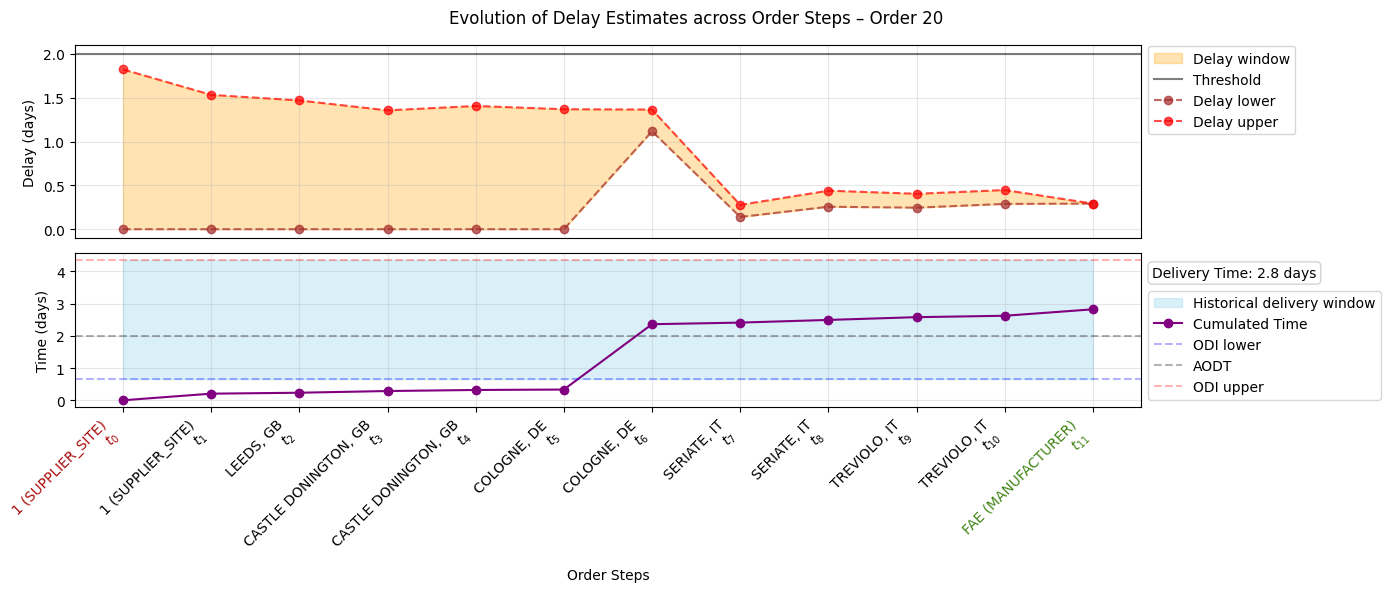

In [2198]:
plot_order_delay_evolution(order_id=sample_order_ids[0], 
                           estimation_by_order=estimation_by_order, 
                           delivery_time_by_order=delivery_time_by_order, 
                           historical_data_by_order=historical_data_by_order)

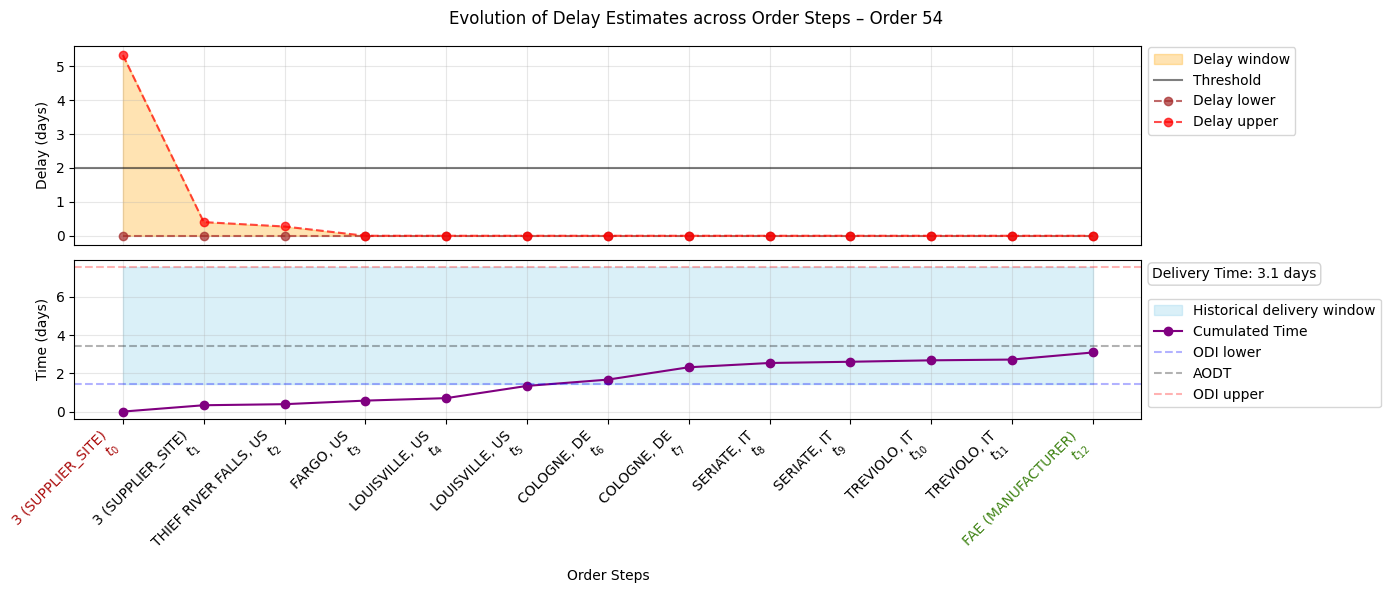

In [2199]:
plot_order_delay_evolution(order_id=sample_order_ids[1], 
                           estimation_by_order=estimation_by_order, 
                           delivery_time_by_order=delivery_time_by_order, 
                           historical_data_by_order=historical_data_by_order)

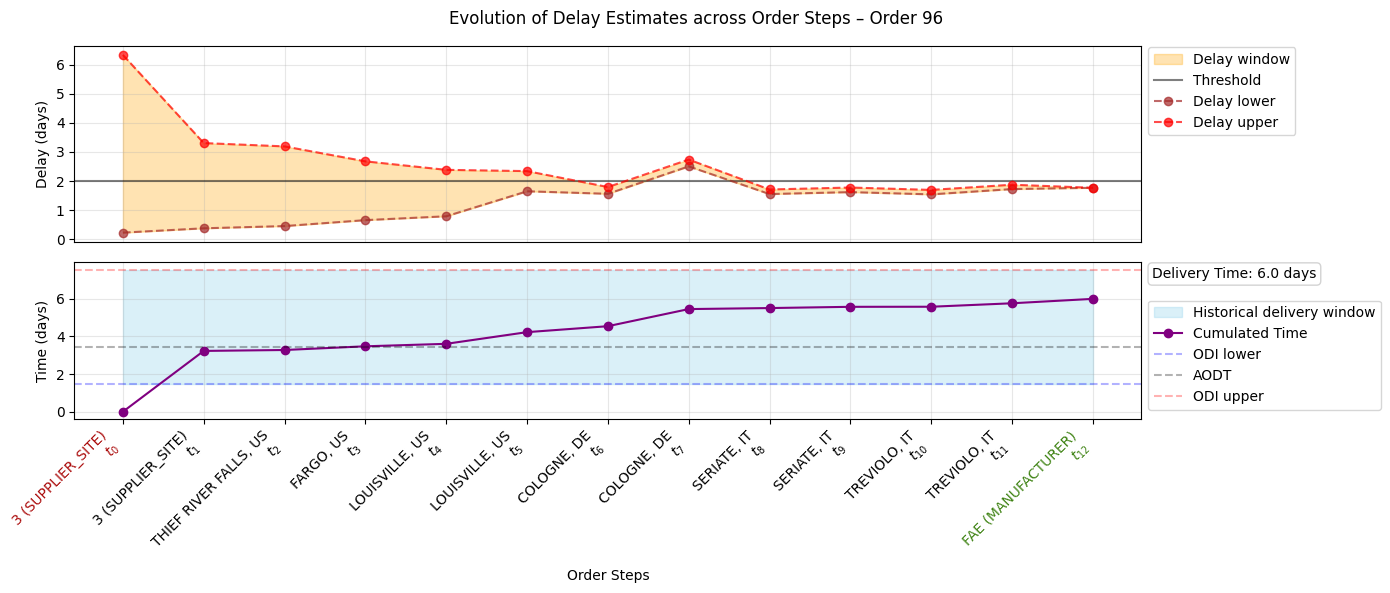

In [2200]:
plot_order_delay_evolution(order_id=sample_order_ids[2], 
                           estimation_by_order=estimation_by_order, 
                           delivery_time_by_order=delivery_time_by_order, 
                           historical_data_by_order=historical_data_by_order)

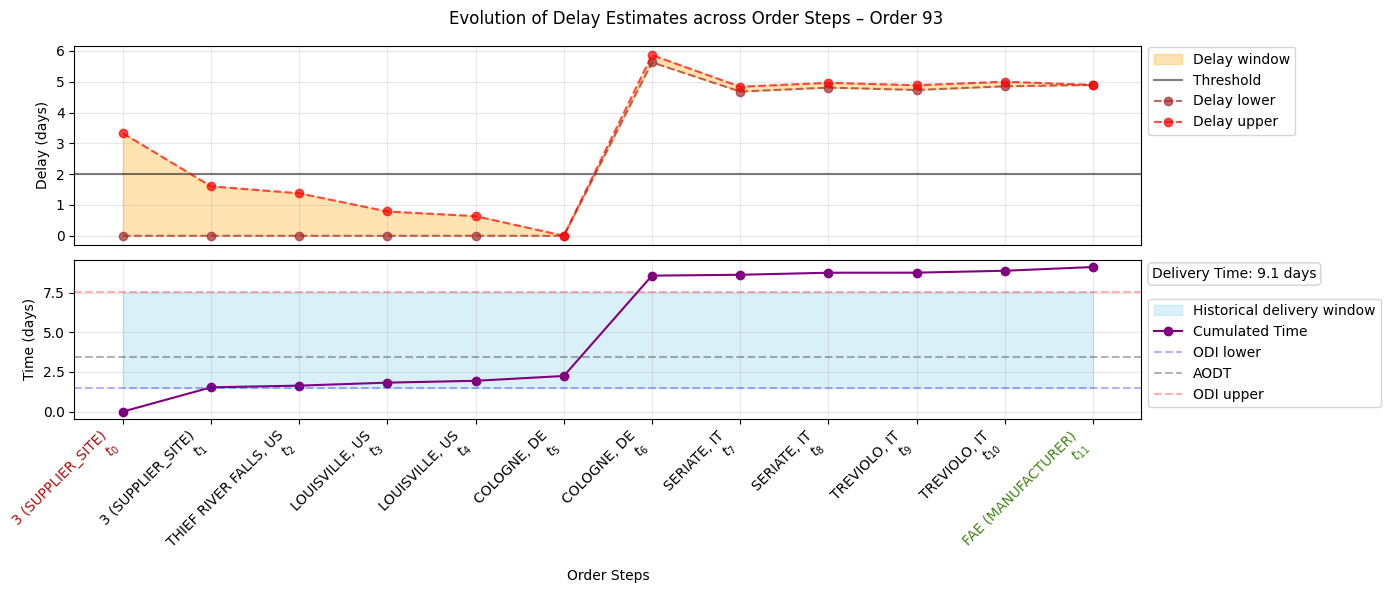

In [2201]:
plot_order_delay_evolution(order_id=sample_order_ids[3], 
                           estimation_by_order=estimation_by_order, 
                           delivery_time_by_order=delivery_time_by_order, 
                           historical_data_by_order=historical_data_by_order)

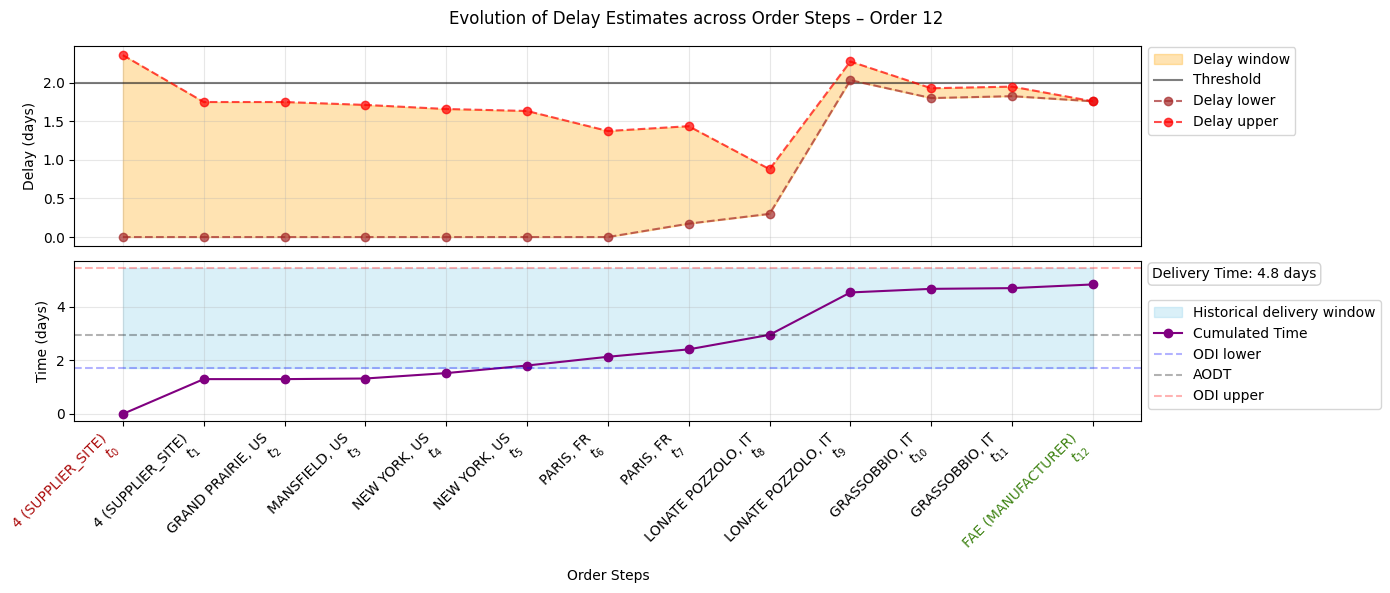

In [2202]:
plot_order_delay_evolution(order_id=sample_order_ids[4], 
                           estimation_by_order=estimation_by_order, 
                           delivery_time_by_order=delivery_time_by_order, 
                           historical_data_by_order=historical_data_by_order)

### Chinese new year

The Chinese New Year in 2025 was celebrated on Wednesday, January 29, marking the beginning of the Year of the Wood Snake according to the Chinese lunisolar calendar. Festivities officially started the evening before, on Tuesday, January 28, with New Year's Eve celebrations, and concluded on Wednesday, February 12 with the Lantern Festival, which celebrates the first full moon of the year.

In China, the official public holiday lasted eight days, from January 28 to February 4, 2025.

In [2203]:
DUMP_FILEPATH: str = "C:/Users/volpato/OneDrive - Cefriel/Desktop/P/FAE/data/distribution_order_dump_2.csv"
dump_df: pd.DataFrame = pd.read_csv(DUMP_FILEPATH)
dump_df.head()

,id,code,estimatedDeliveryDate,status,receivedPackagesCount,distributorId,distributorCode,invoiceCheckDate,invoiceCheckNotes,createdAt,updatedAt,orderConfirmationSent,confirmedDeliveryDate,trackingLink
0,1,517422,2022-11-23 23:00:00,CLOSED,2,1,NaN,NaN,NaN,2023-02-07 14:07:58.736,2023-02-07 14:07:58.736,False,2022-11-23 23:00:00,NaN
1,2,517421,2022-11-24 23:00:00,CLOSED,1,2,NaN,NaN,NaN,2023-02-07 14:07:58.736,2023-02-07 14:07:58.736,False,2022-11-24 23:00:00,NaN
2,3,517423,2022-11-28 23:00:00,CLOSED,1,3,NaN,NaN,NaN,2023-02-07 14:07:58.736,2023-02-07 14:07:58.736,False,2022-11-28 23:00:00,NaN
3,4,AS-29,2022-12-13 23:00:00,FORCE_CLOSED,0,4,NaN,NaN,NaN,2023-02-07 14:07:58.736,2023-10-16 12:29:16.463,False,2022-12-13 23:00:00,NaN
4,5,517436,2022-11-23 23:00:00,CLOSED,1,1,NaN,NaN,NaN,2023-02-07 14:07:58.736,2023-02-07 14:07:58.736,False,2022-11-23 23:00:00,NaN


Chinese sites:

In [2204]:
chinese_sites: pd.DataFrame = sites_df[sites_df["location_name"].str.contains("CN")]
chinese_sites

,id,supplier_id,location_name,n_rejections,n_orders,consider_closure_holidays,consider_working_holidays,consider_weekends_holidays
6,7,4,"SHENZHEN, GUANGDONG, CN",0,1,True,True,True
7,8,5,"DONGGUAN, GUANGDONG, CN",0,2,True,True,True
8,9,5,"SHENZHEN, GUANGDONG, CN",0,1,True,True,True
10,11,7,"ZHUHAI, GUANGDONG, CN",0,1,True,True,True
16,17,11,"SHENZHEN, GUANGDONG, CN",0,3,True,True,True
18,19,13,"SHENZHEN, GUANGDONG, CN",0,1,True,True,True


In [2205]:
chinese_site_ids: List[int] = chinese_sites["id"].tolist()
chinese_orders: pd.DataFrame = orders_df[orders_df["site_id"].isin(chinese_site_ids)]
chinese_orders

,id,manufacturer_id,manufacturer_order_id,site_id,carrier_id,status,n_steps,tracking_link,tracking_number,manufacturer_creation_timestamp,manufacturer_estimated_delivery_timestamp,manufacturer_confirmed_delivery_timestamp,carrier_creation_timestamp,carrier_estimated_delivery_timestamp,carrier_confirmed_delivery_timestamp,SLS,SRS


In [2206]:
chinese_new_year_first_day: datetime = datetime(2025, 1, 28, tzinfo=timezone.utc)

chinese_orders = chinese_orders.copy()
chinese_orders.loc[:, "manufacturer_creation_timestamp"] = pd.to_datetime(
    chinese_orders["manufacturer_creation_timestamp"], utc=True
)

# Filter for orders around Chinese New Year
chinese_new_year_orders: pd.DataFrame = chinese_orders.loc[
    (chinese_orders["manufacturer_creation_timestamp"] >= chinese_new_year_first_day - timedelta(days=10)) & 
    (chinese_orders["manufacturer_creation_timestamp"] <= chinese_new_year_first_day + timedelta(days=15))
]

chinese_new_year_orders

,id,manufacturer_id,manufacturer_order_id,site_id,carrier_id,status,n_steps,tracking_link,tracking_number,manufacturer_creation_timestamp,manufacturer_estimated_delivery_timestamp,manufacturer_confirmed_delivery_timestamp,carrier_creation_timestamp,carrier_estimated_delivery_timestamp,carrier_confirmed_delivery_timestamp,SLS,SRS


Site 10 presents to few data to produce reliable estimations. 
Order 23 from site 16 was already tested in the previous section.

In [2207]:
sites_df[sites_df["supplier_id"].isin(chinese_sites["supplier_id"].unique())]

,id,supplier_id,location_name,n_rejections,n_orders,consider_closure_holidays,consider_working_holidays,consider_weekends_holidays
4,5,4,"MONTAGNOLA, TICINO, CH",0,1,True,True,True
5,6,4,"PEABODY, MASSACHUSETTS, US",0,3,True,True,True
6,7,4,"SHENZHEN, GUANGDONG, CN",0,1,True,True,True
7,8,5,"DONGGUAN, GUANGDONG, CN",0,2,True,True,True
8,9,5,"SHENZHEN, GUANGDONG, CN",0,1,True,True,True
9,10,7,"HONG KONG, UNKNOWN, HK",0,1,True,True,True
10,11,7,"ZHUHAI, GUANGDONG, CN",0,1,True,True,True
16,17,11,"SHENZHEN, GUANGDONG, CN",0,3,True,True,True
18,19,13,"SHENZHEN, GUANGDONG, CN",0,1,True,True,True


Suppliers 10 and 12 have only a single site location in China: we can test the estimation for their orders without tracking link.

In [2208]:
chinese_suppliers_ids: List[int] = [10, 12]
chinese_suppliers: pd.DataFrame = suppliers_df[suppliers_df["id"].isin(chinese_suppliers_ids)]
chinese_suppliers

,id,manufacturer_supplier_id,name
9,10,49,NCAB
11,12,150,AMALFI


In [2209]:
chinese_suppliers_fae_ids: List[int] = chinese_suppliers["manufacturer_supplier_id"].tolist()
chinese_suppliers_fae_ids

[49, 150]

In [2210]:
chinese_dump_orders: pd.DataFrame = dump_df[dump_df["distributorId"].isin(chinese_suppliers_fae_ids)].copy()
chinese_dump_orders.loc[:, "createdAt"] = pd.to_datetime(chinese_dump_orders["createdAt"], utc=True)

chinese_new_year_dump_orders: pd.DataFrame = chinese_dump_orders.loc[
    (chinese_dump_orders["createdAt"] >= chinese_new_year_first_day - timedelta(days=10)) & 
    (chinese_dump_orders["createdAt"] <= chinese_new_year_first_day + timedelta(days=15))
]

chinese_new_year_dump_orders

,id,code,estimatedDeliveryDate,status,receivedPackagesCount,distributorId,distributorCode,invoiceCheckDate,invoiceCheckNotes,createdAt,updatedAt,orderConfirmationSent,confirmedDeliveryDate,trackingLink
4787,6084,NC-1301,2025-02-19 23:00:00,CLOSED,0,49,NaN,2025-03-06 15:05:06.69,25FV-0595,2025-01-20 09:26:05.243000+00:00,2025-03-06 15:05:06.755,False,2025-02-20 10:56:17.239,NaN
4788,6085,NC-1302,2025-03-02 23:00:00,CLOSED,0,49,NaN,2025-04-08 11:55:10.38,25FV-0595 - 25FV-0753,2025-01-20 09:26:08.451000+00:00,2025-04-08 11:55:10.413,False,2025-03-11 13:40:05.599,NaN
4804,6106,NC-1306,2025-03-13 23:00:00,CLOSED,0,49,NaN,2025-04-08 11:54:08.471,25FV-0753,2025-01-23 10:01:27.389000+00:00,2025-04-08 11:54:08.526,False,2025-03-21 11:56:41.943,NaN
4810,6118,NC-1309,2025-02-02 23:00:00,CLOSED,0,49,NaN,2025-02-03 15:15:26.253,25FV-0273,2025-01-23 13:15:36.784000+00:00,2025-02-06 09:00:45.719,False,2025-02-03 14:11:00.873,https://www.dhl.com/it-en/home/tracking.html?t...
4816,6124,NC-1242-1243,2025-03-09 23:00:00,CLOSED,0,49,NaN,2025-04-08 11:54:46.846,25FV-0753,2025-01-24 10:38:04.359000+00:00,2025-04-08 11:54:46.873,False,2025-03-05 07:58:35.229,NaN
4820,6131,NC-1311,2025-02-06 23:00:00,CLOSED,0,49,NaN,2025-02-17 15:42:21.698,25FV-0398,2025-01-27 09:47:02.523000+00:00,2025-02-17 15:42:21.734,False,2025-02-06 07:28:19.874,https://www.dhl.com/it-en/home/tracking.html?t...
4823,6135,NC-1312,2025-02-06 23:00:00,CLOSED,0,49,NaN,2025-02-17 15:42:35.292,25FV-0398,2025-01-27 09:47:26.879000+00:00,2025-02-17 15:42:35.331,False,2025-02-06 13:01:20.435,https://www.dhl.com/it-en/home/tracking.html?t...
4827,6139,NC-1313,2025-02-06 23:00:00,CLOSED,0,49,NaN,2025-02-17 15:42:02.084,25FV-0398,2025-01-27 09:48:03.388000+00:00,2025-02-17 15:42:02.119,False,2025-02-04 15:22:38.265,https://www.dhl.com/it-en/home/tracking.html?t...
4841,6154,NC-1316,2025-02-05 23:00:00,CLOSED,0,49,NaN,2025-02-17 15:42:51.485,25FV-0398,2025-01-28 13:14:58.818000+00:00,2025-02-17 15:42:51.513,False,2025-02-07 13:39:40.957,NaN
4845,6161,NC-1317,2025-02-05 23:00:00,CLOSED,0,49,NaN,2025-02-17 15:46:10.591,25FV-0398,2025-01-29 10:46:59.116000+00:00,2025-02-17 15:46:10.616,False,2025-02-11 09:17:40.778,NaN


The only order for which the chinese site is note and the order creation is near the festivity was already tested.